#### 1. LogisticRegression

In [30]:
# Step 1: Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay

In [31]:
# Step 2: Load the dataset
df = pd.read_csv("scaled_dataset.csv")

In [32]:
# Step 3: Separate features and target
X = df.drop(columns=['Satisfaction_Satisfied'])
y = df['Satisfaction_Satisfied']

In [33]:

# Step 4: Train-test split (80/20) with stratification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)

#### Hayper Parameter Tunning

In [149]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

# Define the model
logreg = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

# Define the hyperparameters to tune
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],          # Regularization strength
    'solver': ['liblinear', 'saga'],       # Solvers compatible with L1 or L2
    'penalty': ['l1', 'l2'],               # Regularization type
}

# Setup GridSearchCV
grid_search = GridSearchCV(logreg, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit to training data
grid_search.fit(X_train, y_train)

# Print best parameters and score
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Accuracy:", grid_search.best_score_)

# Use the best model
best_logreg = grid_search.best_estimator_


Best Parameters: {'C': 0.01, 'penalty': 'l1', 'solver': 'saga'}
Best Cross-Validation Accuracy: 0.8109999999999999


In [34]:
# Initialize Logistic Regression with best hyperparameters from tuning
logreg = LogisticRegression(  
    class_weight='balanced',    # Handle class imbalance by adjusting weights
    max_iter=1000,              # Increase max iterations to ensure convergence
    random_state=42,            # Set random seed for reproducibility
    C=0.01,                     # Regularization strength (smaller = stronger regularization)
    penalty='l1',               # Use L1 regularization (feature selection)
    solver='saga'               # 'saga' solver supports L1 with large datasets
)

# Fit the model to the training data
logreg.fit(X_train, y_train)   # Train the logistic regression model

LogisticRegression(C=0.01, class_weight='balanced', max_iter=1000, penalty='l1',
                   random_state=42, solver='saga')

In [35]:
# Step 6: Make predictions
y_pred = logreg.predict(X_test)

In [36]:
# Step 7: Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report_dict = classification_report(y_test, y_pred, target_names=['Dissatisfied', 'Satisfied'], output_dict=True)

# Convert to DataFrame
report_df = pd.DataFrame(report_dict).transpose()

# Round the values for better presentation
report_df = report_df.round(4)

# Add accuracy as a separate row
report_df.loc['accuracy'] = [accuracy, None, None, None]

# Display the table
print("Logistic Regression - Classification Report\n")
print(report_df)

Logistic Regression - Classification Report

              precision  recall  f1-score  support
Dissatisfied     0.6147  0.7203    0.6633   1001.0
Satisfied        0.9010  0.8493    0.8744   2999.0
accuracy         0.8170     NaN       NaN      NaN
macro avg        0.7578  0.7848    0.7688   4000.0
weighted avg     0.8293  0.8170    0.8215   4000.0


#### Visualizing Accuracy for Logistic Regression

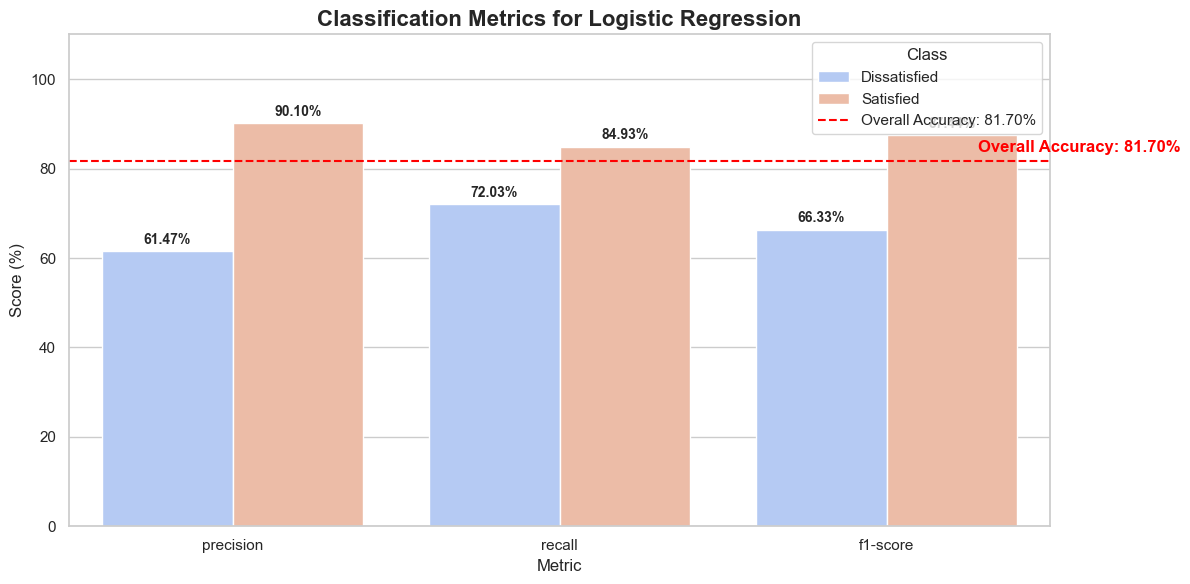

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Filter only the class rows (exclude accuracy, macro avg, etc.)
class_metrics = report_df.loc[['Dissatisfied', 'Satisfied'], ['precision', 'recall', 'f1-score']]

# Step 2: Reset index and melt DataFrame for plotting
class_metrics = class_metrics.reset_index().melt(id_vars='index', var_name='Metric', value_name='Score')
class_metrics.rename(columns={'index': 'Class'}, inplace=True)

# Step 3: Convert scores to percentage
class_metrics['Score'] = class_metrics['Score'] * 100

# Step 4: Extract and format accuracy
accuracy_percent = float(report_df.loc['accuracy', 'precision']) * 100
accuracy_label = f"Overall Accuracy: {accuracy_percent:.2f}%"

# Step 5: Plot
plt.figure(figsize=(12, 6))
ax = sns.barplot(data=class_metrics, x='Metric', y='Score', hue='Class', palette='coolwarm')

# Add value labels to bars (excluding 0.00%)
for bar in ax.patches:
    height = bar.get_height()
    if height > 0:
        x = bar.get_x() + bar.get_width() / 2
        ax.text(x, height + 1, f'{height:.2f}%', ha='center', va='bottom', fontsize=10, weight='bold')

# Add horizontal accuracy line and label
plt.axhline(accuracy_percent, color='red', linestyle='--', linewidth=1.5, label=accuracy_label)
plt.text(
    x=2.9, y=accuracy_percent + 2,
    s=accuracy_label,
    color='red',
    fontsize=12,
    ha='right',
    fontweight='bold'
)

# Styling
plt.ylim(0, 110)
plt.title('Classification Metrics for Logistic Regression', fontsize=16, fontweight='bold')
plt.ylabel('Score (%)')
plt.xlabel('Metric')
plt.legend(title='Class')
plt.tight_layout()
plt.show()

#### Classification Report

Correctly classified predictions: 3268
Incorrectly classified predictions: 732


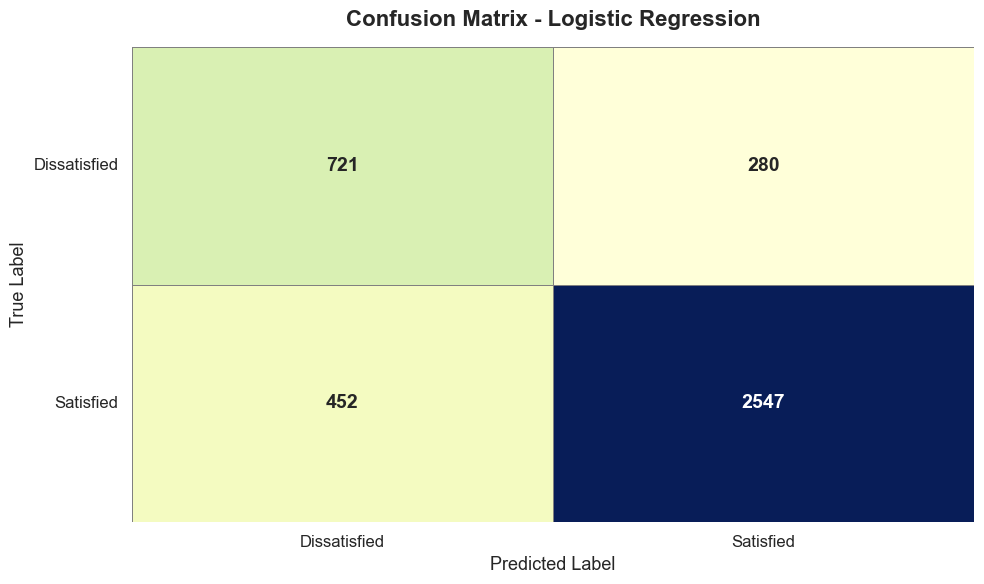

In [38]:
from sklearn.metrics import confusion_matrix

# Step 8: Get predictions from the model
y_pred = logreg.predict(X_test)

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Print correctly and incorrectly classified predictions
correctly_classified = (y_pred == y_test).sum()
incorrectly_classified = (y_pred != y_test).sum()

# Print the results
print(f"Correctly classified predictions: {correctly_classified}")
print(f"Incorrectly classified predictions: {incorrectly_classified}")

# Labels for the confusion matrix plot
labels = ['Dissatisfied', 'Satisfied']

# Plot confusion matrix with heatmap
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")

# Draw heatmap with enhanced formatting
ax = sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='YlGnBu',
    xticklabels=labels,
    yticklabels=labels,
    cbar=False,
    linewidths=0.5,
    linecolor='gray',
    annot_kws={"size": 14, "weight": "bold"}
)

# Add labels and title with better formatting
plt.title("Confusion Matrix - Logistic Regression", fontsize=16, fontweight='bold', pad=15)
plt.xlabel("Predicted Label", fontsize=13)
plt.ylabel("True Label", fontsize=13)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12, rotation=0)
plt.tight_layout()
plt.show()

#### Visualizing Training and Testing Accuracy

In [39]:
from sklearn.metrics import accuracy_score

# Step 4: Evaluate training and testing accuracy
# Predict on training and test data
y_train_pred = logreg.predict(X_train)
y_test_pred = logreg.predict(X_test)

# Calculate accuracy for training and testing sets
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

# Print the results
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Testing Accuracy: {test_accuracy:.4f}")


Training Accuracy: 0.8136
Testing Accuracy: 0.8170


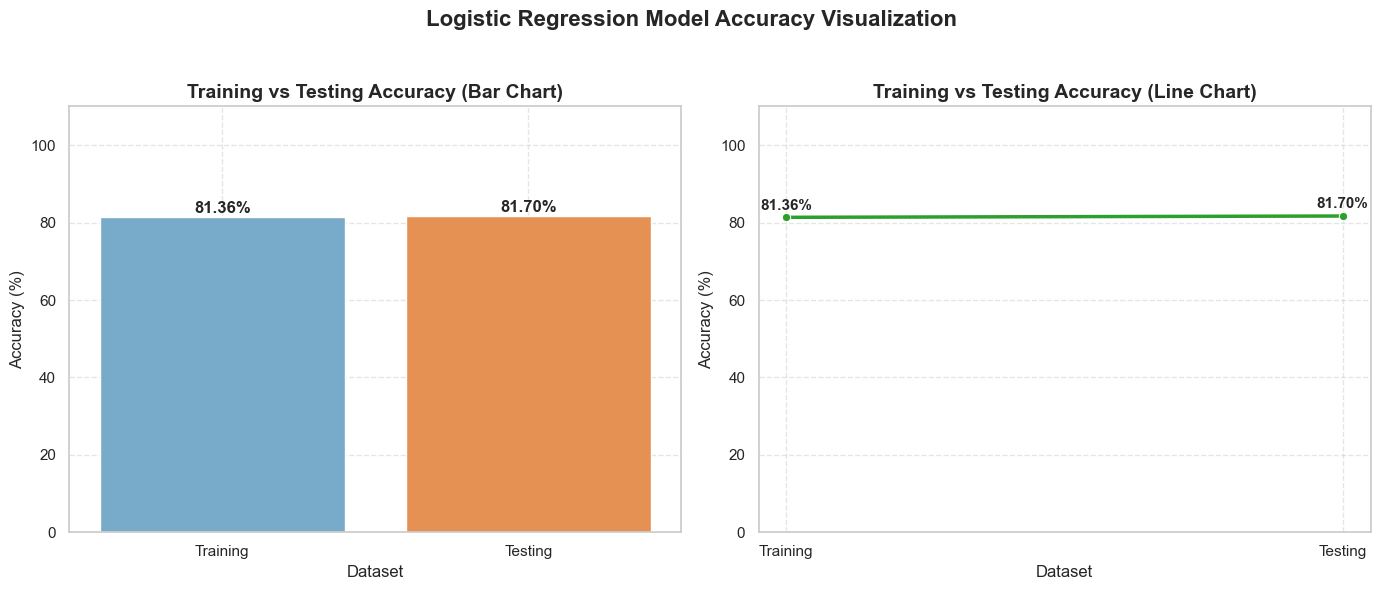

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import accuracy_score

# Accuracy scores
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

# Convert to percentage
train_acc_percent = train_accuracy * 100
test_acc_percent = test_accuracy * 100

# Prepare data for plotting
acc_df = pd.DataFrame({
    'Dataset': ['Training', 'Testing'],
    'Accuracy': [train_acc_percent, test_acc_percent]
})

# Updated custom colors
colors = ['#6BAED6', '#FD8D3C']

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# --- Bar Chart ---
sns.barplot(data=acc_df, x='Dataset', y='Accuracy', palette=colors, ax=axes[0])

# Add labels on bars
for i, row in acc_df.iterrows():
    axes[0].text(i, row['Accuracy'] + 1, f"{row['Accuracy']:.2f}%", ha='center', fontsize=12, fontweight='bold')

axes[0].set_ylim(0, 110)
axes[0].set_title("Training vs Testing Accuracy (Bar Chart)", fontsize=14, fontweight='bold')
axes[0].set_ylabel("Accuracy (%)")
axes[0].grid(True, linestyle='--', alpha=0.5)

# --- Line Chart ---
sns.lineplot(data=acc_df, x='Dataset', y='Accuracy', marker='o', linewidth=2.5, ax=axes[1], color='#2CA02C')
axes[1].set_ylim(0, 110)
axes[1].set_title("Training vs Testing Accuracy (Line Chart)", fontsize=14, fontweight='bold')
axes[1].set_ylabel("Accuracy (%)")
axes[1].grid(True, linestyle='--', alpha=0.5)

# Add labels to line plot points
for i, row in acc_df.iterrows():
    axes[1].text(i, row['Accuracy'] + 2, f"{row['Accuracy']:.2f}%", ha='center', fontsize=11, fontweight='bold')

# Final layout
plt.suptitle("Logistic Regression Model Accuracy Visualization", fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


#### Model Interpretability

* Logistic Regression is inherently interpretable. Coefficients indicate the impact of each feature.

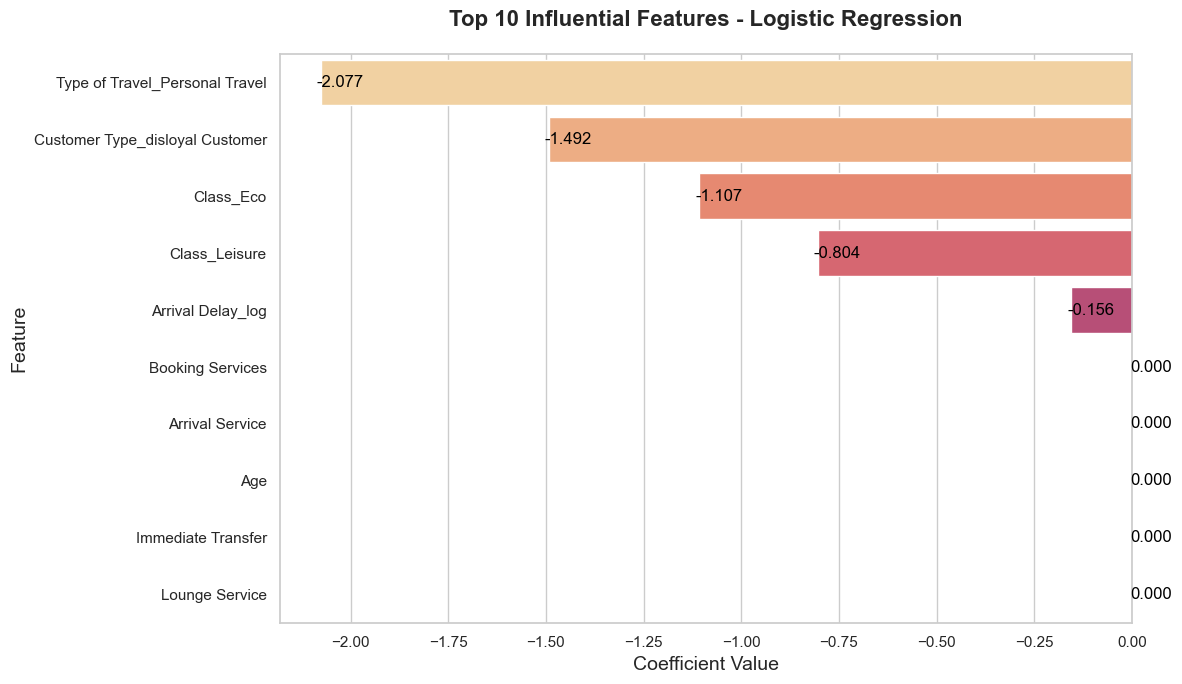

In [102]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Extract feature names and coefficients
coefficients = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': logreg.coef_[0]
})
coefficients['Abs_Coefficient'] = coefficients['Coefficient'].abs()
coefficients.sort_values(by='Abs_Coefficient', ascending=False, inplace=True)

# Plot top influential features
plt.figure(figsize=(12, 7))
sns.barplot(data=coefficients.head(10), x='Coefficient', y='Feature', palette='magma_r', dodge=False)

# Add annotations for the coefficient values
for index, value in enumerate(coefficients['Coefficient'].head(10)):
    plt.text(value + 0.05, index, f'{value:.3f}', color='black', ha='center', va='center')

# Add title and labels with improved styling
plt.title('Top 10 Influential Features - Logistic Regression', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Coefficient Value', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.tight_layout()

# Show plot
plt.show()

#### 2. Decision Tree

In [41]:
# Step 1: Import Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.tree import plot_tree

In [42]:
# Step 2: Load and Split the Dataset
# Load dataset
dataset = pd.read_csv('scaled_dataset.csv')

# Split into features and target
X = dataset.drop(columns=['Satisfaction_Satisfied'])
y = dataset['Satisfaction_Satisfied']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

#### Hyperparameter Tuning for Decision Tree

In [43]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

# Define the model
dt_model = DecisionTreeClassifier(random_state=42)

# Define the hyperparameters to tune
param_grid = {
    'criterion': ['gini', 'entropy'],                # Split criteria (Gini or Information Gain)
    'max_depth': [None, 5, 10, 15, 20],               # Max depth of the tree
    'min_samples_split': [2, 5, 10, 20],              # Minimum samples required to split an internal node
    'min_samples_leaf': [1, 2, 5, 10],                # Minimum samples required to be at a leaf node
    'max_features': [None, 'sqrt', 'log2'],           # Number of features to consider at each split
}

# Setup GridSearchCV
grid_search = GridSearchCV(estimator=dt_model, param_grid=param_grid, cv=5, n_jobs=-1, scoring='accuracy')

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

# Print best parameters and score
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Accuracy:", grid_search.best_score_)

# Use the best model
best_dt_model = grid_search.best_estimator_

Best Parameters: {'criterion': 'gini', 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 5, 'min_samples_split': 20}
Best Cross-Validation Accuracy: 0.8416250000000002


#### Step 3: Train the Decision Tree Model

In [44]:
# Initialize and train Decision Tree with best tuned parameters
dt_model = DecisionTreeClassifier(
    criterion='gini',            # Use Gini impurity (best from tuning)
    max_depth=5,                 # Limit depth to prevent overfitting (best from tuning)
    min_samples_split=20,        # Require at least 20 samples to split (best from tuning)
    min_samples_leaf=5,          # Require at least 5 samples per leaf (best from tuning)
    max_features=None,           # Consider all features at each split (best from tuning)
    random_state=42              # Set random seed for reproducibility
)

# Train the model on the training data
dt_model.fit(X_train, y_train)


DecisionTreeClassifier(max_depth=5, min_samples_leaf=5, min_samples_split=20,
                       random_state=42)

In [45]:
# Step 4: Make Predictions
y_pred = dt_model.predict(X_test)

#### Classification Report

Correctly classified predictions: 3349
Incorrectly classified predictions: 651


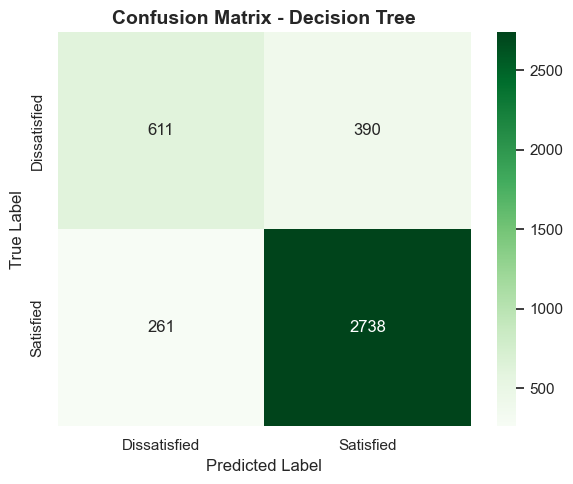

In [46]:
from sklearn.metrics import confusion_matrix

# Step 5: Make predictions on the test set
y_pred = dt_model.predict(X_test)

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Calculate correctly and incorrectly classified predictions
correctly_classified = (y_pred == y_test).sum()
incorrectly_classified = (y_pred != y_test).sum()

# Print the results
print(f"Correctly classified predictions: {correctly_classified}")
print(f"Incorrectly classified predictions: {incorrectly_classified}")

# Labels for the confusion matrix plot
labels = ['Dissatisfied', 'Satisfied']

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix - Decision Tree", fontsize=14, fontweight='bold')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

In [47]:
#Step 6: Classification Report Table
accuracy = accuracy_score(y_test, y_pred)
report_dict = classification_report(y_test, y_pred, target_names=['Dissatisfied', 'Satisfied'], output_dict=True)

# Convert to DataFrame
report_df = pd.DataFrame(report_dict).transpose()
report_df = report_df.round(4)

# Add accuracy as a separate row (under 'precision' column)
report_df.loc['accuracy'] = [accuracy, None, None, None]
print("Decision Tree - Classification Report\n")
print(report_df)

Decision Tree - Classification Report

              precision  recall  f1-score  support
Dissatisfied    0.70070  0.6104    0.6524   1001.0
Satisfied       0.87530  0.9130    0.8937   2999.0
accuracy        0.83725     NaN       NaN      NaN
macro avg       0.78800  0.7617    0.7731   4000.0
weighted avg    0.83160  0.8372    0.8334   4000.0


#### Visualizing The overall accuracy

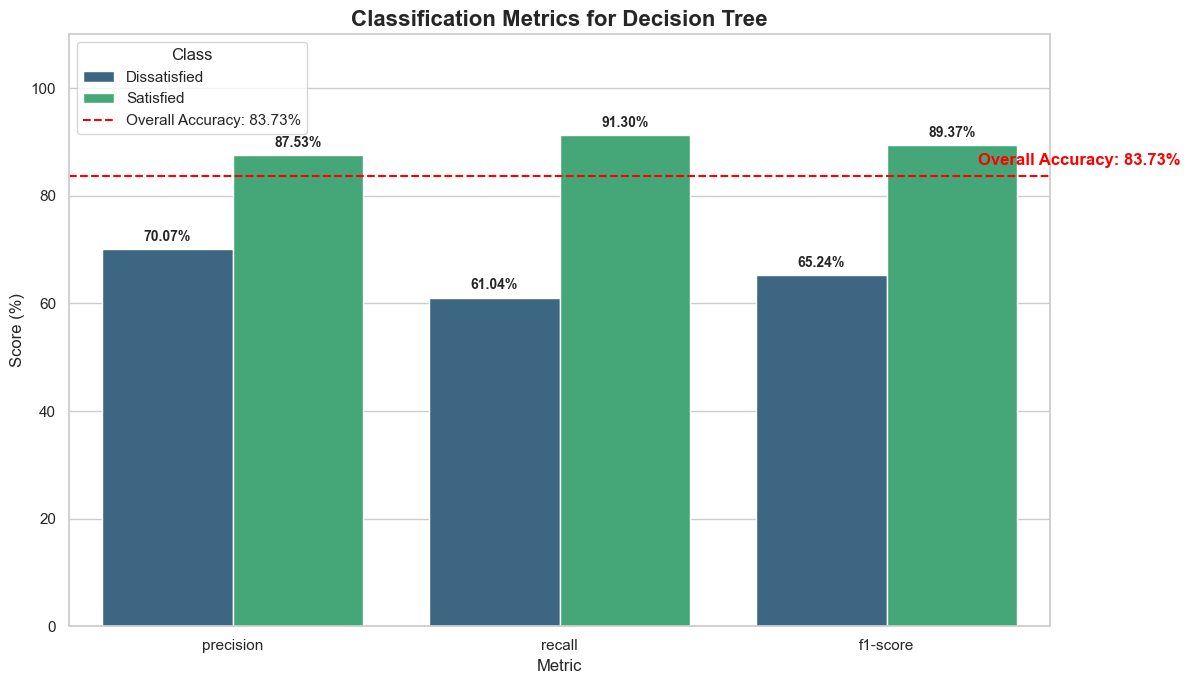

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter only class rows (Dissatisfied and Satisfied)
class_metrics = report_df.loc[['Dissatisfied', 'Satisfied'], ['precision', 'recall', 'f1-score']]

# Prepare for plotting
class_metrics = class_metrics.reset_index().melt(id_vars='index', var_name='Metric', value_name='Score')
class_metrics.rename(columns={'index': 'Class'}, inplace=True)

# Convert scores to percentage
class_metrics['Score'] = class_metrics['Score'] * 100

# Extract accuracy
accuracy_percent = float(report_df.loc['accuracy', 'precision']) * 100
accuracy_label = f"Overall Accuracy: {accuracy_percent:.2f}%"

# Plot
plt.figure(figsize=(12, 7))
ax = sns.barplot(data=class_metrics, x='Metric', y='Score', hue='Class', palette='viridis')

# Add percentage labels to bars
for bar in ax.patches:
    height = bar.get_height()
    if height > 0:  # Skip 0.00%
        x = bar.get_x() + bar.get_width() / 2
        ax.text(x, height + 1, f'{height:.2f}%', ha='center', va='bottom', fontsize=10, weight='bold')

# Add accuracy line
plt.axhline(accuracy_percent, color='red', linestyle='--', linewidth=1.5, label=accuracy_label)
plt.text(
    x=2.9, y=accuracy_percent + 2,
    s=accuracy_label,
    color='red',
    fontsize=12,
    ha='right',
    fontweight='bold'
)

# Styling
plt.ylim(0, 110)
plt.title('Classification Metrics for Decision Tree', fontsize=16, fontweight='bold')
plt.ylabel('Score (%)')
plt.xlabel('Metric')
plt.legend(title='Class')
plt.tight_layout()
plt.show()


#### Visualizing Training and Testing Accuracy

In [49]:
from sklearn.metrics import accuracy_score
# Predict on training and test data
y_train_pred = dt_model.predict(X_train)
y_test_pred = dt_model.predict(X_test)

# Calculate accuracy for training and testing sets
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

# Print the results
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Testing Accuracy: {test_accuracy:.4f}")


Training Accuracy: 0.8452
Testing Accuracy: 0.8373


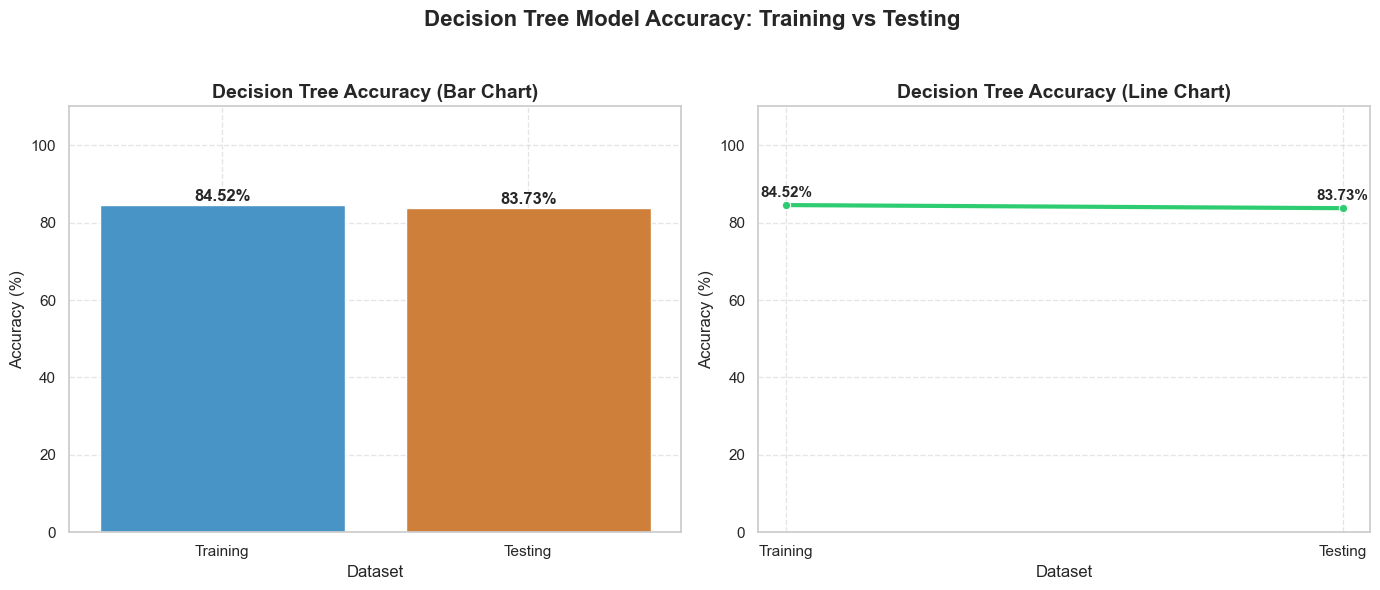

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import accuracy_score

# Step 1: Predict on training and testing sets
y_train_pred = dt_model.predict(X_train)
y_test_pred = dt_model.predict(X_test)

# Step 2: Calculate accuracy
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

# Step 3: Convert to percentages
train_acc_percent = train_accuracy * 100
test_acc_percent = test_accuracy * 100

# Step 4: Create DataFrame
acc_df = pd.DataFrame({
    'Dataset': ['Training', 'Testing'],
    'Accuracy': [train_acc_percent, test_acc_percent]
})

# Step 5: Set modern style
sns.set(style='whitegrid')

# Step 6: Create subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# --- Bar Chart ---
sns.barplot(data=acc_df, x='Dataset', y='Accuracy', palette=['#3498DB', '#E67E22'], ax=axes[0])
axes[0].set_title("Decision Tree Accuracy (Bar Chart)", fontsize=14, fontweight='bold')
axes[0].set_ylabel("Accuracy (%)")
axes[0].set_ylim(0, 110)
axes[0].grid(True, linestyle='--', alpha=0.5)

# Add labels on bars
for i, row in acc_df.iterrows():
    axes[0].text(i, row['Accuracy'] + 1, f"{row['Accuracy']:.2f}%", ha='center', fontsize=12, fontweight='bold')

# --- Line Chart ---
sns.lineplot(data=acc_df, x='Dataset', y='Accuracy', marker='o', linewidth=3, color='#2ECC71', ax=axes[1])
axes[1].set_title("Decision Tree Accuracy (Line Chart)", fontsize=14, fontweight='bold')
axes[1].set_ylabel("Accuracy (%)")
axes[1].set_ylim(0, 110)
axes[1].grid(True, linestyle='--', alpha=0.5)

# Add labels on points
for i, row in acc_df.iterrows():
    axes[1].text(i, row['Accuracy'] + 2, f"{row['Accuracy']:.2f}%", ha='center', fontsize=11, fontweight='bold')

# Step 7: Final layout
plt.suptitle("Decision Tree Model Accuracy: Training vs Testing", fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


#### Model Interpretability

* You can visualize the decision rules with plot_tree.

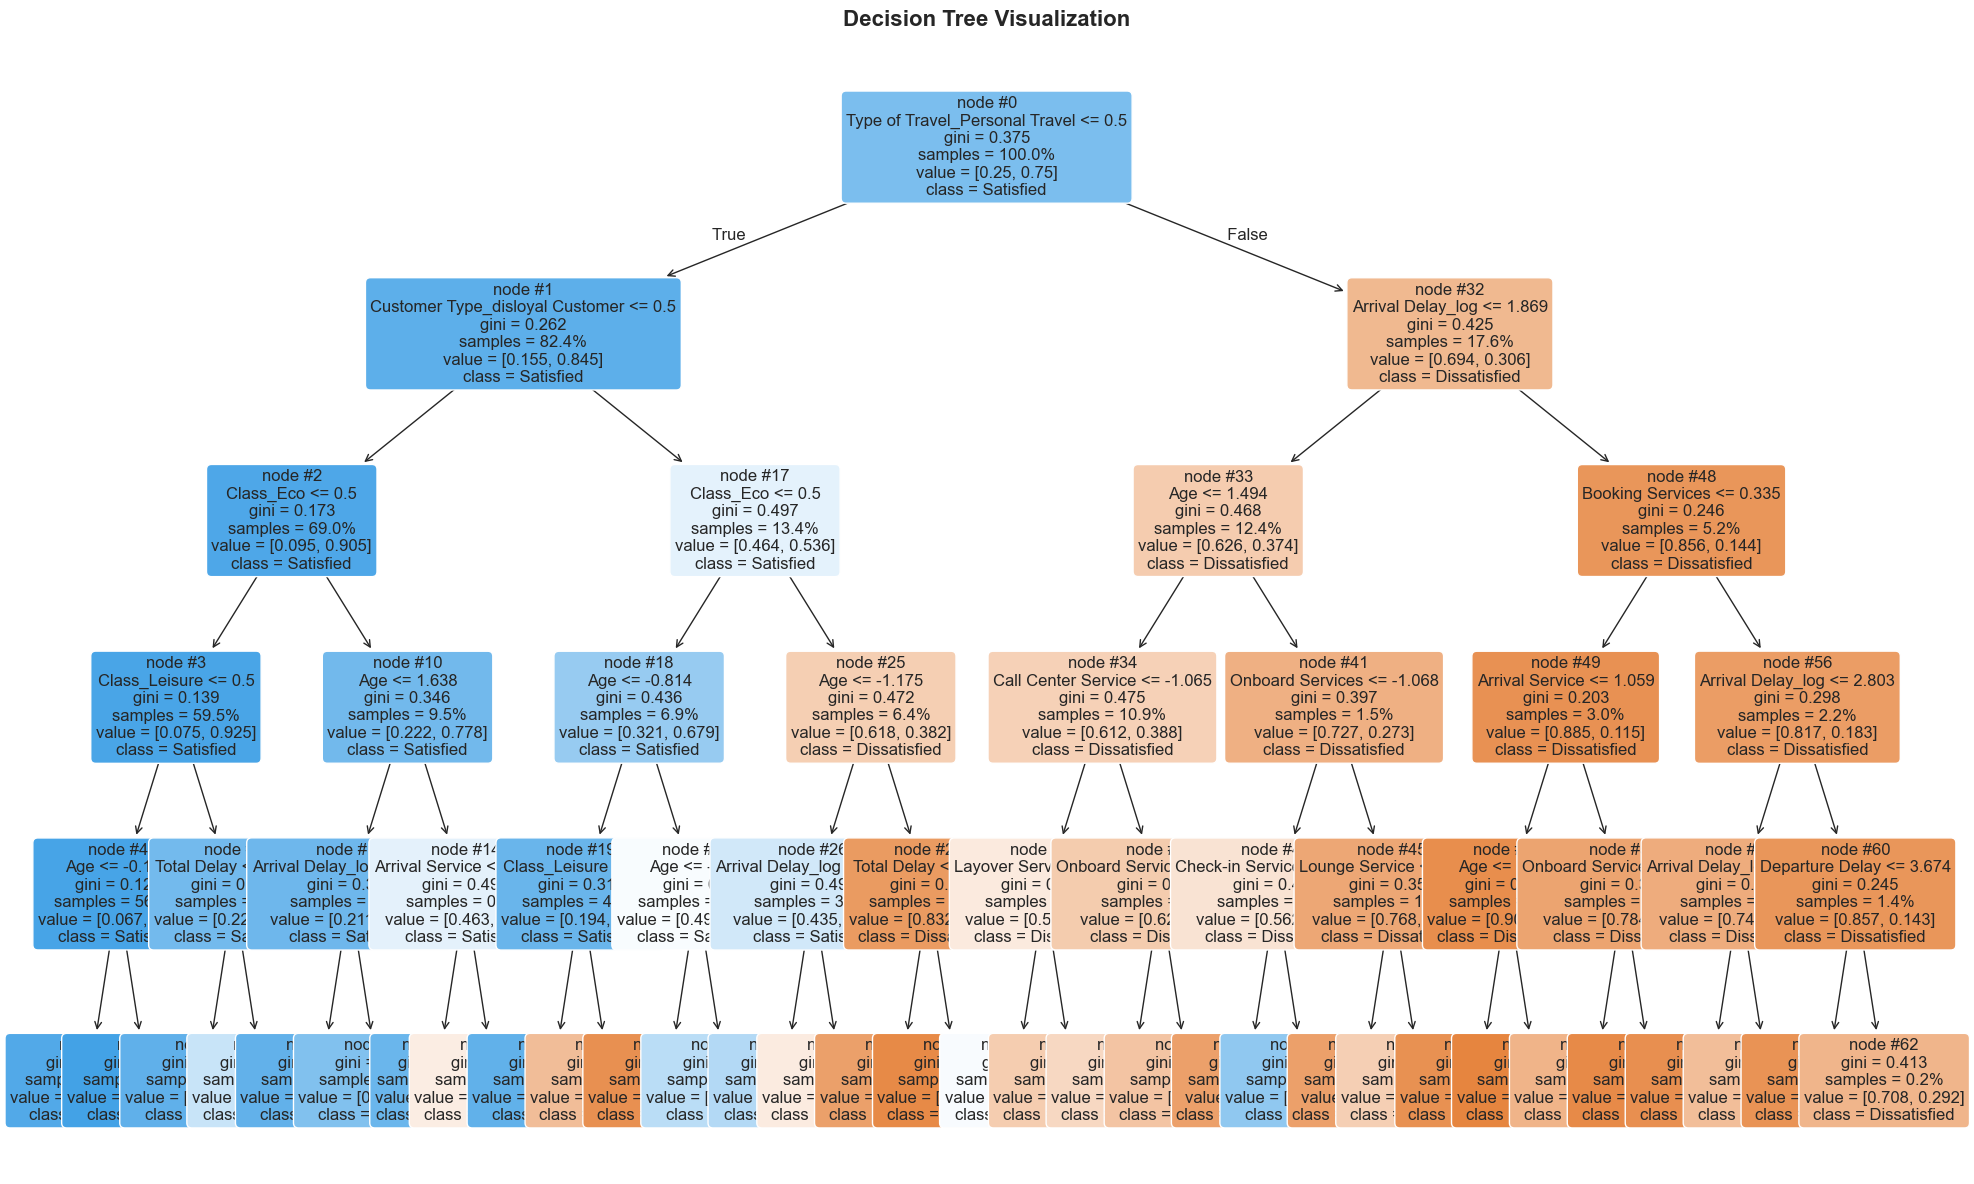

In [103]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Set figure size for better clarity
plt.figure(figsize=(20, 12))

# Plot the decision tree with styling enhancements
plot_tree(
    dt_model,
    feature_names=X_train.columns,   # Display feature names
    class_names=labels,              # Display class labels
    filled=True,                     # Fill nodes with colors based on the class
    rounded=True,                    # Rounded corners for a cleaner look
    fontsize=12,                     # Increase font size for readability
    node_ids=True,                   # Display node ids for clarity
    proportion=True,                 # Proportional distribution of classes in nodes
    precision=3                      # Show values with 3 decimal places
)

# Add a title with enhanced styling
plt.title('Decision Tree Visualization', fontsize=16, fontweight='bold', pad=20)

# Display the tree plot
plt.tight_layout()
plt.show()

#### 3. Random Forest

In [51]:
# Step 1: Import Libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [52]:
# Step 2: Load and Split the Dataset
# Load dataset
dataset = pd.read_csv('scaled_dataset.csv')

# Split into features and target
X = dataset.drop(columns=['Satisfaction_Satisfied'])
y = dataset['Satisfaction_Satisfied']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

#### Hyperparameter Tuning

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Define the Random Forest model
rf_model = RandomForestClassifier(random_state=42)

# Define the hyperparameters grid
param_grid = {
    'n_estimators': [50, 100, 200],                  # Number of trees in the forest
    'criterion': ['gini', 'entropy'],                # Function to measure quality of a split
    'max_depth': [None, 10, 20, 30],                  # Max depth of the tree
    'min_samples_split': [2, 5, 10],                  # Minimum samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],                    # Minimum samples required to be at a leaf node
    'max_features': ['sqrt', 'log2', None],           # Number of features to consider at each split
    'bootstrap': [True, False],                       # Whether to use bootstrap sampling
    'class_weight': ['balanced', None]                # Whether to balance class weights
}

# Setup GridSearchCV to find the best combination of parameters
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, n_jobs=-1, scoring='accuracy')

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

# Print best parameters and score
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Accuracy:", grid_search.best_score_)

# Use the best model found from the grid search
best_rf_model = grid_search.best_estimator_


In [53]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(
    n_estimators=100,                 # Number of trees in the forest
    criterion='gini',                 # Function to measure the quality of a split: 'gini' or 'entropy'
    max_depth=None,                  # Max depth of the tree (None means nodes are expanded until all leaves are pure)
    min_samples_split=2,            # Minimum number of samples required to split an internal node
    min_samples_leaf=1,             # Minimum number of samples required to be at a leaf node
    min_weight_fraction_leaf=0.0,   # Minimum weighted fraction of the sum total of weights required to be at a leaf node
    max_features='sqrt',            # Number of features to consider when looking for the best split
    max_leaf_nodes=None,            # Grow trees with max_leaf_nodes in best-first fashion
    min_impurity_decrease=0.0,      # Node will be split if this split induces a decrease of impurity greater than or equal to this value
    bootstrap=True,                 # Whether bootstrap samples are used when building trees
    oob_score=False,                # Whether to use out-of-bag samples to estimate the generalization score
    n_jobs=-1,                      # Number of jobs to run in parallel (-1 means using all processors)
    random_state=42,                # Seed for reproducibility
    verbose=0,                      # Controls the verbosity when fitting and predicting
    warm_start=False,               # Reuse the solution of the previous call to fit and add more estimators to the ensemble
    class_weight='balanced',        # Automatically adjust weights inversely proportional to class frequencies
    ccp_alpha=0.0,                  # Complexity parameter used for Minimal Cost-Complexity Pruning
    max_samples=None                # Number of samples to draw from X to train each base estimator (only if bootstrap=True)
)

rf_model.fit(X_train, y_train)


RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=42)

In [54]:
#Step 3: Make Predictions
y_pred = rf_model.predict(X_test)

#### Classification Report

Correctly classified predictions: 3334
Incorrectly classified predictions: 666


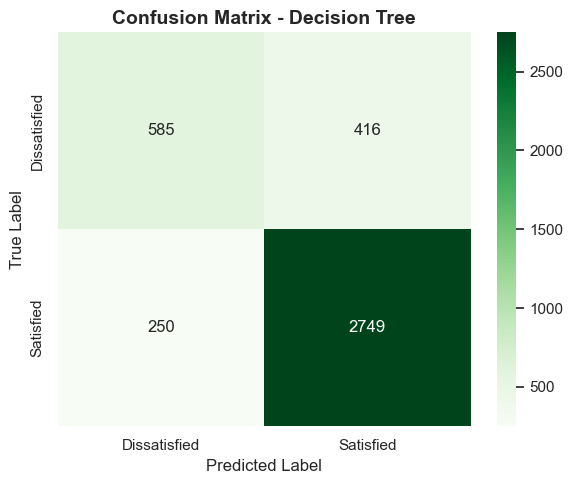

In [55]:
from sklearn.metrics import confusion_matrix

# Step 5: Make predictions on the test set
y_pred = rf_model.predict(X_test)

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Calculate correctly and incorrectly classified predictions
correctly_classified = (y_pred == y_test).sum()
incorrectly_classified = (y_pred != y_test).sum()

# Print the results
print(f"Correctly classified predictions: {correctly_classified}")
print(f"Incorrectly classified predictions: {incorrectly_classified}")

# Labels for the confusion matrix plot
labels = ['Dissatisfied', 'Satisfied']

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix - Decision Tree", fontsize=14, fontweight='bold')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

In [56]:
# Step 4: Generate Classification Report and Accuracy
accuracy = accuracy_score(y_test, y_pred)
report_dict = classification_report(
    y_test, y_pred,
    target_names=['Dissatisfied', 'Satisfied'],
    output_dict=True
)
print("Random Forest - Classification Report\n", accuracy)

Random Forest - Classification Report
 0.8335


In [57]:
#Step 5: Convert Report to DataFrame and Add Accuracy
report_df = pd.DataFrame(report_dict).transpose().round(4)
report_df.loc['accuracy'] = [accuracy, None, None, None]
print("Random Forest - Classification Report\n")
print(report_df)

Random Forest - Classification Report

              precision  recall  f1-score  support
Dissatisfied     0.7006  0.5844    0.6373   1001.0
Satisfied        0.8686  0.9166    0.8920   2999.0
accuracy         0.8335     NaN       NaN      NaN
macro avg        0.7846  0.7505    0.7646   4000.0
weighted avg     0.8265  0.8335    0.8282   4000.0


In [58]:
#Step 6: Prepare Data for Visualization
# Filter class-specific metrics only
class_metrics = report_df.loc[['Dissatisfied', 'Satisfied'], ['precision', 'recall', 'f1-score']]

# Reshape for plotting
class_metrics = class_metrics.reset_index().melt(id_vars='index', var_name='Metric', value_name='Score')
class_metrics.rename(columns={'index': 'Class'}, inplace=True)

# Convert scores to percentage
class_metrics['Score'] = class_metrics['Score'] * 100


In [59]:
#Step 7: Extract Accuracy for Display
accuracy_percent = accuracy * 100
accuracy_label = f"Overall Accuracy: {accuracy_percent:.2f}%"


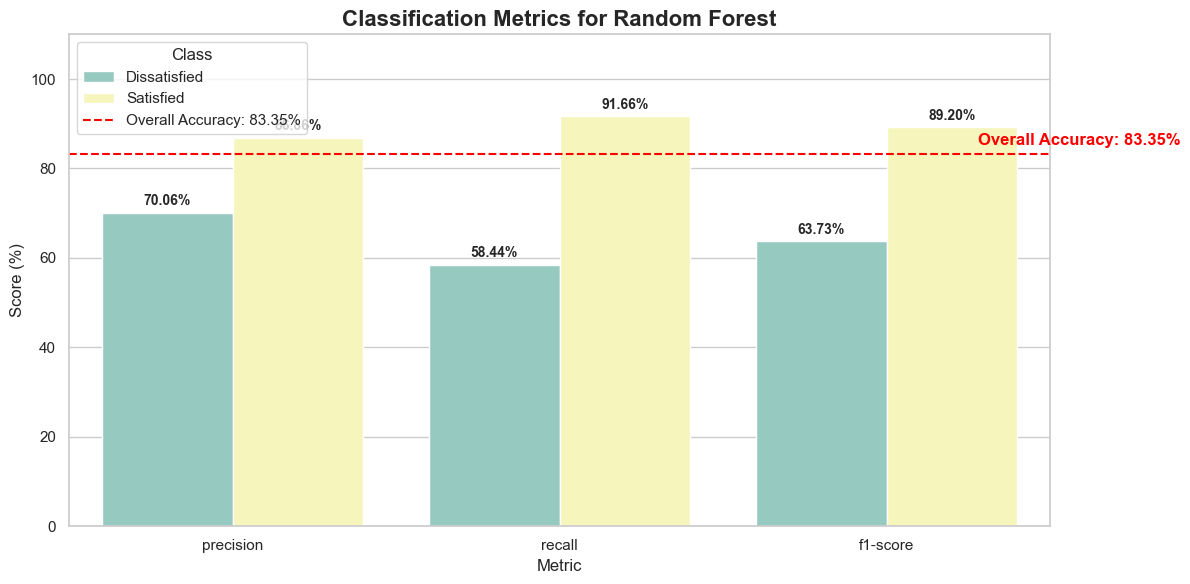

In [60]:
#Step 8: Plot Classification Metrics
plt.figure(figsize=(12, 6))
ax = sns.barplot(data=class_metrics, x='Metric', y='Score', hue='Class', palette='Set3')
for bar in ax.patches:
    height = bar.get_height()
    if height > 0:
        x = bar.get_x() + bar.get_width() / 2
        ax.text(x, height + 1, f'{height:.2f}%', ha='center', va='bottom', fontsize=10, weight='bold')
plt.axhline(accuracy_percent, color='red', linestyle='--', linewidth=1.5, label=accuracy_label)
plt.text(
    x=2.9, y=accuracy_percent + 2,
    s=accuracy_label,
    color='red',
    fontsize=12,
    ha='right',
    fontweight='bold'
)

plt.ylim(0, 110)
plt.title('Classification Metrics for Random Forest', fontsize=16, fontweight='bold')
plt.ylabel('Score (%)')
plt.xlabel('Metric')
plt.legend(title='Class')
plt.tight_layout()
plt.show()

#### Visualizing Training and Testing Accuarcy

In [61]:
from sklearn.metrics import accuracy_score
# Predict on training and test data
y_train_pred = rf_model.predict(X_train)
y_test_pred = rf_model.predict(X_test)

# Calculate accuracy for training and testing sets
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

# Print the results
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Testing Accuracy: {test_accuracy:.4f}")


Training Accuracy: 0.9999
Testing Accuracy: 0.8335


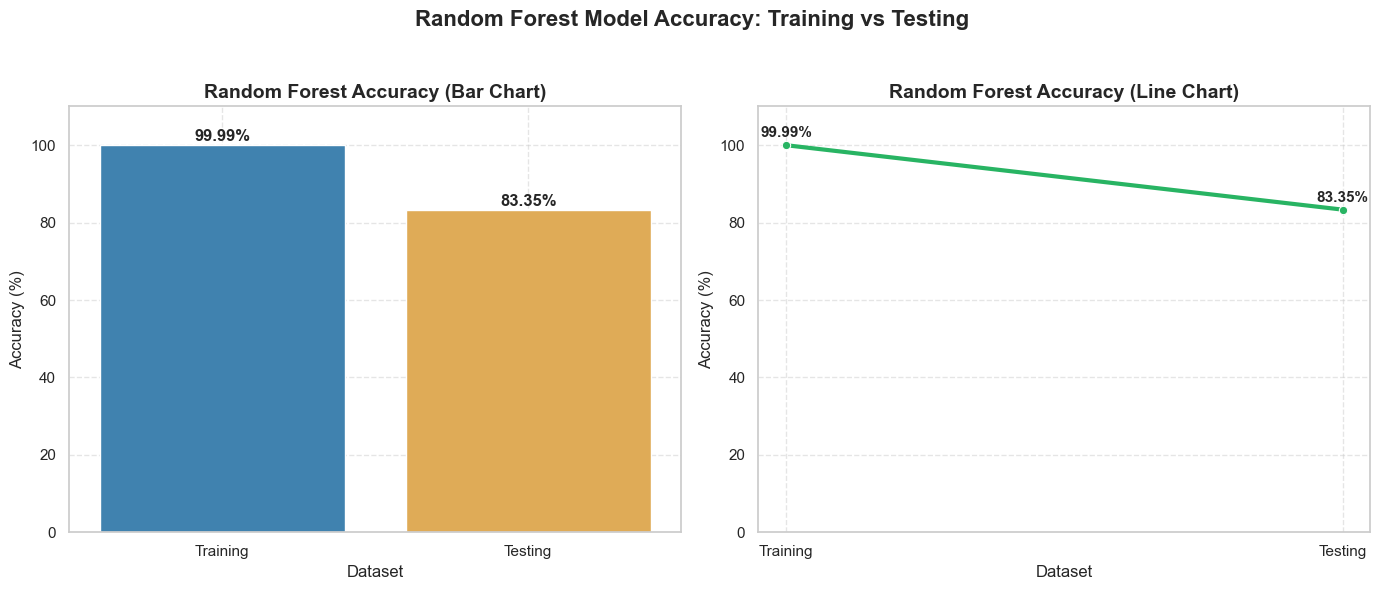

In [62]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import accuracy_score

# Step 1: Predict
y_train_pred = rf_model.predict(X_train)
y_test_pred = rf_model.predict(X_test)

# Step 2: Accuracy scores
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

# Step 3: Convert to percentage
train_acc_percent = train_accuracy * 100
test_acc_percent = test_accuracy * 100

# Step 4: Prepare DataFrame
acc_df = pd.DataFrame({
    'Dataset': ['Training', 'Testing'],
    'Accuracy': [train_acc_percent, test_acc_percent]
})

# Step 5: Set style
sns.set(style='whitegrid')

# Step 6: Create subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# --- Bar Chart ---
sns.barplot(data=acc_df, x='Dataset', y='Accuracy', palette=['#2E86C1', '#F5B041'], ax=axes[0])
axes[0].set_title("Random Forest Accuracy (Bar Chart)", fontsize=14, fontweight='bold')
axes[0].set_ylabel("Accuracy (%)")
axes[0].set_ylim(0, 110)
axes[0].grid(True, linestyle='--', alpha=0.5)

# Add labels on bars
for i, row in acc_df.iterrows():
    axes[0].text(i, row['Accuracy'] + 1, f"{row['Accuracy']:.2f}%", ha='center', fontsize=12, fontweight='bold')

# --- Line Chart ---
sns.lineplot(data=acc_df, x='Dataset', y='Accuracy', marker='o', linewidth=3, color='#28B463', ax=axes[1])
axes[1].set_title("Random Forest Accuracy (Line Chart)", fontsize=14, fontweight='bold')
axes[1].set_ylabel("Accuracy (%)")
axes[1].set_ylim(0, 110)
axes[1].grid(True, linestyle='--', alpha=0.5)

# Add labels on points
for i, row in acc_df.iterrows():
    axes[1].text(i, row['Accuracy'] + 2, f"{row['Accuracy']:.2f}%", ha='center', fontsize=11, fontweight='bold')

# Step 7: Final layout
plt.suptitle("Random Forest Model Accuracy: Training vs Testing", fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


#### Model Interpretability

* Random Forests aggregate many trees, so we rely on feature importance scores.

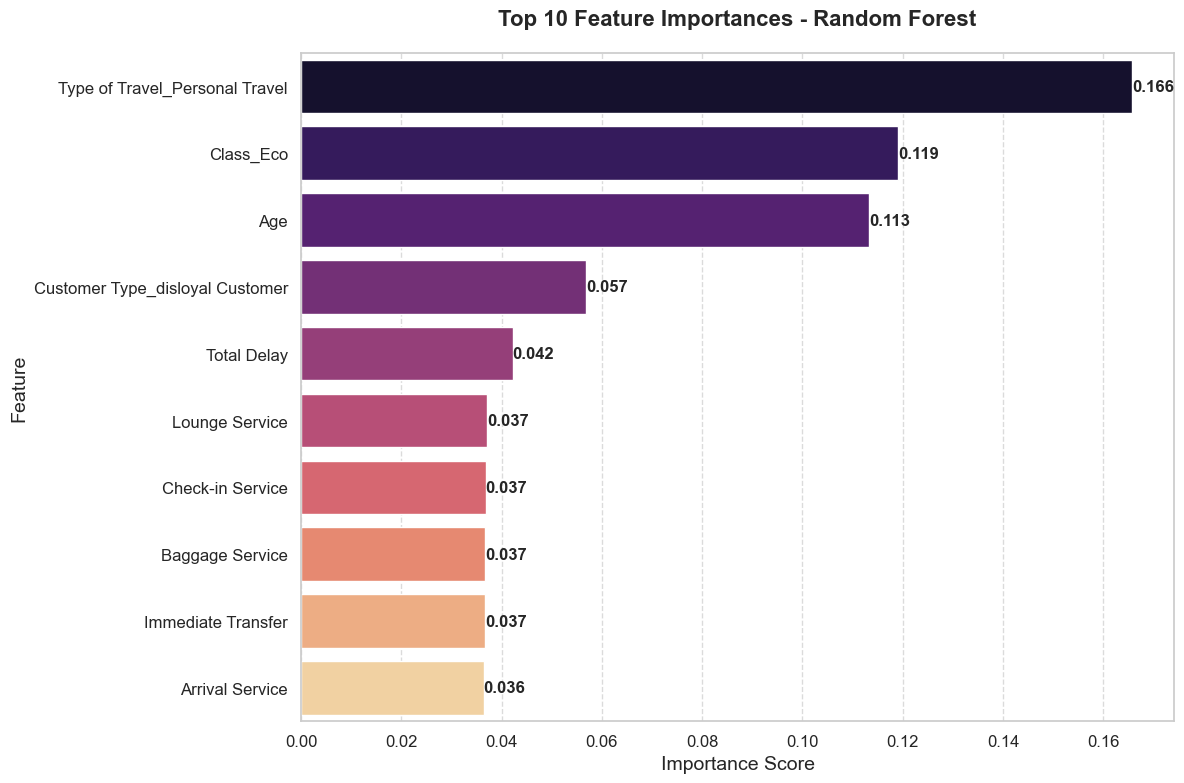

In [105]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Get feature importances
importances = pd.Series(rf_model.feature_importances_, index=X_train.columns)
importances = importances.sort_values(ascending=False)

# Plot
plt.figure(figsize=(12, 8))

# Use a more vibrant color palette for better visibility
sns.barplot(x=importances[:10], y=importances[:10].index, palette='magma')

# Enhance plot styling
plt.title('Top 10 Feature Importances - Random Forest', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Importance Score', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add gridlines for better readability
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Add values on top of the bars
for index, value in enumerate(importances[:10]):
    plt.text(value, index, f'{value:.3f}', va='center', ha='left', fontsize=12, fontweight='bold')

# Ensure tight layout for a clean presentation
plt.tight_layout()
plt.show()

#### 4. Support Vector Machine (SVM)

In [63]:
# Step 1: Import Libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt


In [64]:
# Step 2: Load and Prepare the Data
# Load dataset
dataset = pd.read_csv('scaled_dataset.csv')
# Assuming X and y are already defined (features and target variable)
X = dataset.drop(columns=['Satisfaction_Satisfied'])  # Replace with your feature columns
y = dataset['Satisfaction_Satisfied']  # Replace with your target variable column


In [65]:
# Step 3: Split the Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


#### SVM Hyperparameter Tuning

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# Create a base SVM model
svm_model = SVC(class_weight='balanced')  # Handle imbalance if needed

# Define the parameter grid
param_grid = {
    'C': [0.01, 0.1, 1, 10],                   # Regularization strength
    'kernel': ['linear', 'rbf', 'poly'],       # Different kernel types
    'gamma': ['scale', 'auto', 0.001, 0.01, 0.1],  # Kernel coefficient
    'degree': [2, 3, 4]                        # Only used for 'poly' kernel
}

# Setup GridSearchCV
grid_search = GridSearchCV(estimator=svm_model, param_grid=param_grid, 
                           cv=5, n_jobs=-1, scoring='accuracy', verbose=1)

# Fit to training data
grid_search.fit(X_train, y_train)

# Print best parameters and best cross-validation score
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Accuracy:", grid_search.best_score_)

# Retrieve the best model
best_svm_model = grid_search.best_estimator_


Fitting 5 folds for each of 180 candidates, totalling 900 fits


In [66]:
# Step 4: Train the Support Vector Machine (SVM) Model
svm_model = SVC(
    C=1.0,                        # Regularization parameter (higher = less regularization)
    kernel='rbf',                 # Kernel type: 'rbf' (radial basis function)
    degree=3,                     # Degree for 'poly' kernel (ignored by other kernels)
    gamma='scale',                # Kernel coefficient for 'rbf', 'poly', and 'sigmoid'
    coef0=0.0,                    # Independent term in kernel function
    shrinking=True,               # Use shrinking heuristic (faster training)
    probability=True,             # Enable probability estimates
    tol=1e-3,                     # Tolerance for stopping criterion
    cache_size=200,               # Size of kernel cache (in MB)
    class_weight='balanced',      # Handle unbalanced class weights
    verbose=False,                # Disable verbose output
    random_state=42               # Reproducibility
)

# Fit the model to the training data
svm_model.fit(X_train, y_train)


SVC(class_weight='balanced', probability=True, random_state=42)

In [67]:
# Step 5: Make Predictions
# Predict on the test set
y_pred = svm_model.predict(X_test)

#### Classification Report

Correctly classified predictions: 3244
Incorrectly classified predictions: 756


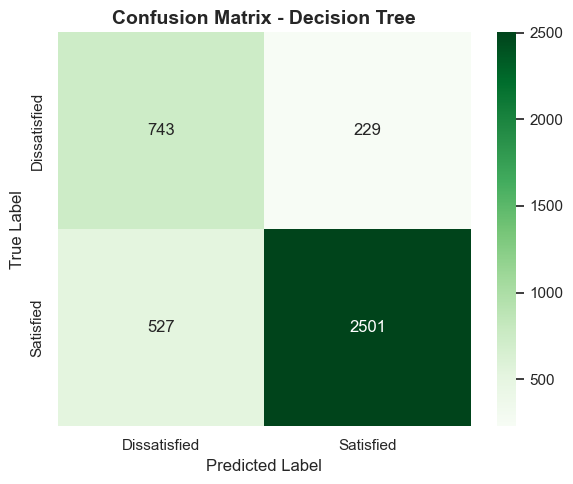

In [68]:
from sklearn.metrics import confusion_matrix

# Step 5: Make predictions on the test set
y_pred = svm_model.predict(X_test)

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Calculate correctly and incorrectly classified predictions
correctly_classified = (y_pred == y_test).sum()
incorrectly_classified = (y_pred != y_test).sum()

# Print the results
print(f"Correctly classified predictions: {correctly_classified}")
print(f"Incorrectly classified predictions: {incorrectly_classified}")

# Labels for the confusion matrix plot
labels = ['Dissatisfied', 'Satisfied']

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix - Decision Tree", fontsize=14, fontweight='bold')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

In [69]:
#  Step 6: Evaluate the Model - Classification Report
# Get accuracy score
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%\n")

# Classification report
report_dict = classification_report(y_test, y_pred, target_names=['Dissatisfied', 'Satisfied'], output_dict=True)

# Convert to DataFrame for easy visualization
report_df = pd.DataFrame(report_dict).transpose()
report_df = report_df.round(4)

# Add accuracy as a separate row
report_df.loc['accuracy'] = [accuracy, None, None, None]
print("SVM - Classification Report\n")
print(report_df)


Accuracy: 81.10%

SVM - Classification Report

              precision  recall  f1-score  support
Dissatisfied     0.5850  0.7644    0.6628    972.0
Satisfied        0.9161  0.8260    0.8687   3028.0
accuracy         0.8110     NaN       NaN      NaN
macro avg        0.7506  0.7952    0.7658   4000.0
weighted avg     0.8357  0.8110    0.8187   4000.0


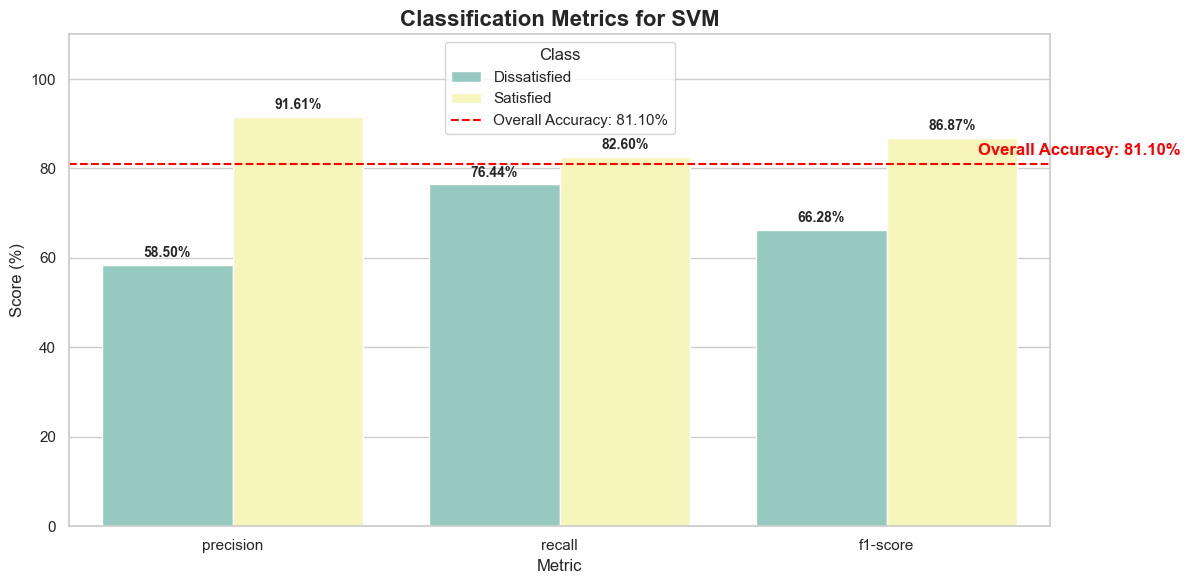

In [70]:
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Filter only the class rows (Dissatisfied and Satisfied)
class_metrics = report_df.loc[['Dissatisfied', 'Satisfied'], ['precision', 'recall', 'f1-score']]

# Step 2: Prepare for plotting
class_metrics = class_metrics.reset_index().melt(id_vars='index', var_name='Metric', value_name='Score')
class_metrics.rename(columns={'index': 'Class'}, inplace=True)

# Step 3: Convert scores to percentage
class_metrics['Score'] = class_metrics['Score'] * 100

# Step 4: Extract accuracy and label
accuracy_percent = float(report_df.loc['accuracy', 'precision']) * 100
accuracy_label = f"Overall Accuracy: {accuracy_percent:.2f}%"

# Step 5: Plot Classification Metrics
plt.figure(figsize=(12, 6))
ax = sns.barplot(data=class_metrics, x='Metric', y='Score', hue='Class', palette='Set3')

# Add value labels above bars (excluding 0.00%)
for bar in ax.patches:
    height = bar.get_height()
    if height > 0:
        x = bar.get_x() + bar.get_width() / 2
        ax.text(x, height + 1, f'{height:.2f}%', ha='center', va='bottom', fontsize=10, weight='bold')

# Add horizontal accuracy line and label
plt.axhline(accuracy_percent, color='red', linestyle='--', linewidth=1.5, label=accuracy_label)
plt.text(
    x=2.9, y=accuracy_percent + 2,
    s=accuracy_label,
    color='red',
    fontsize=12,
    ha='right',
    fontweight='bold'
)

# Styling
plt.ylim(0, 110)
plt.title('Classification Metrics for SVM', fontsize=16, fontweight='bold')
plt.ylabel('Score (%)')
plt.xlabel('Metric')
plt.legend(title='Class')
plt.tight_layout()
plt.show()


#### Visualizing Training and Testing Accuracy

In [71]:
from sklearn.metrics import accuracy_score
# Predict on training and test data
y_train_pred = svm_model.predict(X_train)
y_test_pred = svm_model.predict(X_test)

# Calculate accuracy for training and testing sets
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

# Print the results
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Testing Accuracy: {test_accuracy:.4f}")


Training Accuracy: 0.8153
Testing Accuracy: 0.8110


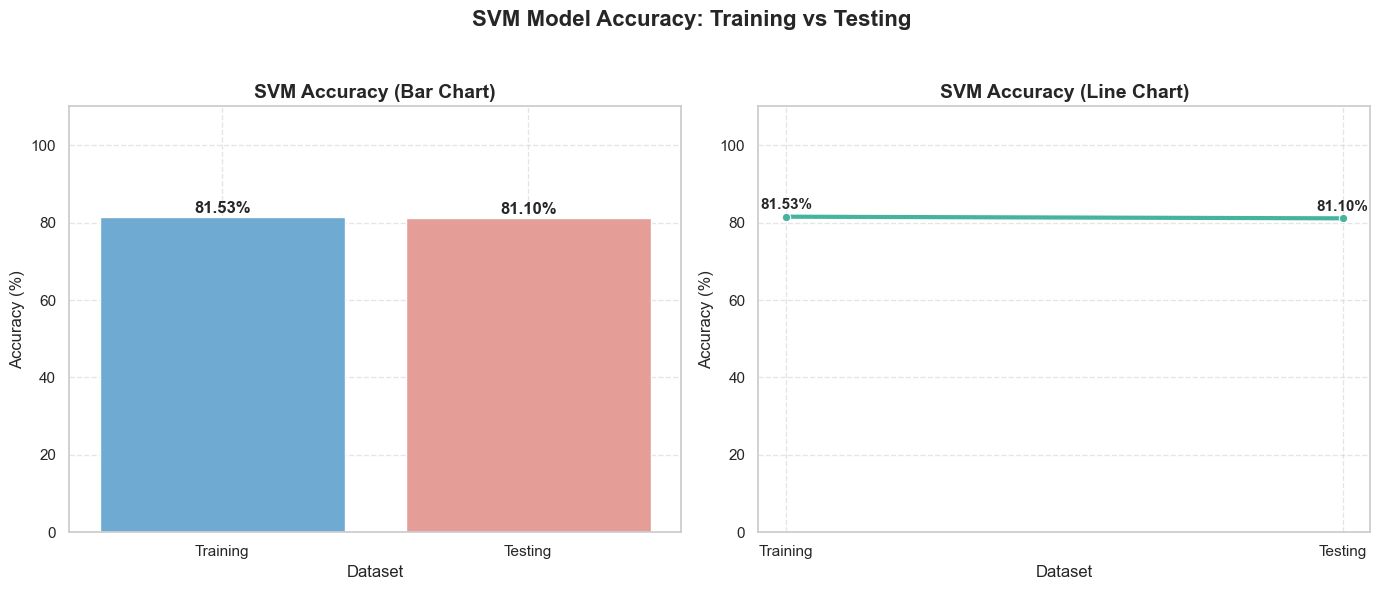

In [72]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import accuracy_score

# Step 1: Predict
y_train_pred = svm_model.predict(X_train)
y_test_pred = svm_model.predict(X_test)

# Step 2: Accuracy scores
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

# Step 3: Convert to percentage
train_acc_percent = train_accuracy * 100
test_acc_percent = test_accuracy * 100

# Step 4: Prepare DataFrame
acc_df = pd.DataFrame({
    'Dataset': ['Training', 'Testing'],
    'Accuracy': [train_acc_percent, test_acc_percent]
})

# Step 5: Set style
sns.set(style='whitegrid')

# Step 6: Create subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# --- Bar Chart ---
sns.barplot(data=acc_df, x='Dataset', y='Accuracy', palette=['#5DADE2', '#F1948A'], ax=axes[0])
axes[0].set_title("SVM Accuracy (Bar Chart)", fontsize=14, fontweight='bold')
axes[0].set_ylabel("Accuracy (%)")
axes[0].set_ylim(0, 110)
axes[0].grid(True, linestyle='--', alpha=0.5)

# Add labels on bars
for i, row in acc_df.iterrows():
    axes[0].text(i, row['Accuracy'] + 1, f"{row['Accuracy']:.2f}%", ha='center', fontsize=12, fontweight='bold')

# --- Line Chart ---
sns.lineplot(data=acc_df, x='Dataset', y='Accuracy', marker='o', linewidth=3, color='#45B39D', ax=axes[1])
axes[1].set_title("SVM Accuracy (Line Chart)", fontsize=14, fontweight='bold')
axes[1].set_ylabel("Accuracy (%)")
axes[1].set_ylim(0, 110)
axes[1].grid(True, linestyle='--', alpha=0.5)

# Add labels on points
for i, row in acc_df.iterrows():
    axes[1].text(i, row['Accuracy'] + 2, f"{row['Accuracy']:.2f}%", ha='center', fontsize=11, fontweight='bold')

# Step 7: Final layout
plt.suptitle("SVM Model Accuracy: Training vs Testing", fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

#### Model Interpretability

* Since SVMs aren’t inherently interpretable, we use SHAP values.

  0%|          | 0/100 [00:00<?, ?it/s]

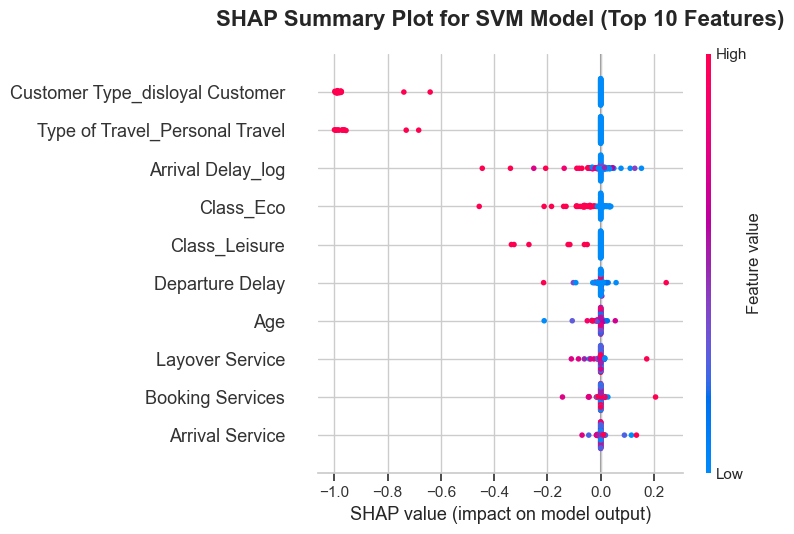

In [106]:
import shap
import matplotlib.pyplot as plt

# Fit an explainer (kernel-based for SVMs)
explainer = shap.KernelExplainer(svm_model.predict, shap.kmeans(X_train, 10))
shap_values = explainer.shap_values(X_test[:100], nsamples=100)

# Plot summary with styling improvements
plt.figure(figsize=(12, 8))

# Customize SHAP summary plot
shap.summary_plot(shap_values, X_test[:100], feature_names=X_test.columns, plot_type="dot", 
                  color_bar=True, max_display=10, show=False)

# Customize plot appearance
plt.title('SHAP Summary Plot for SVM Model (Top 10 Features)', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()

# Show plot
plt.show()


#### 5. XGBoost

In [73]:
# Step 1: Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

In [74]:
# Load the dataset from the previous session (already loaded as 'df') and prepare X and y
X = dataset.drop(columns='Satisfaction_Satisfied')  # Features
y = df['Satisfaction_Satisfied']  # Target variable

In [75]:
# Step 2: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


#### Hyperparameter Tuning

In [ ]:
# Import necessary modules
from xgboost import XGBClassifier  # XGBoost classifier for gradient boosting
from sklearn.model_selection import GridSearchCV  # Grid search for hyperparameter tuning

# Initialize the base XGBoost model
# - use_label_encoder=False: avoids deprecation warning
# - eval_metric='logloss': evaluation metric for binary classification
# - random_state=42: ensures reproducibility
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Define the hyperparameter grid for tuning
# Each key corresponds to a hyperparameter of XGBClassifier
param_grid = {
    'n_estimators': [100, 200],          # Number of trees (boosting rounds)
    'max_depth': [3, 5, 7],              # Maximum tree depth for base learners
    'learning_rate': [0.01, 0.1, 0.2],   # Step size shrinkage used in update
    'subsample': [0.8, 1.0],             # Subsample ratio of training data
    'colsample_bytree': [0.8, 1.0],      # Subsample ratio of columns when constructing each tree
    'gamma': [0, 1, 5],                  # Minimum loss reduction to make a split
    'reg_alpha': [0, 0.1, 1],            # L1 regularization term on weights
    'reg_lambda': [1, 5, 10]             # L2 regularization term on weights
}

# Set up the GridSearchCV
# - estimator: base model to tune
# - param_grid: dictionary of parameters to search
# - scoring: metric to evaluate the model (accuracy here)
# - cv: 5-fold cross-validation
# - n_jobs=-1: use all available CPU cores
# - verbose=1: print progress
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid,
                           scoring='accuracy', cv=5, verbose=1, n_jobs=-1)

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

# Output the best hyperparameters and best score from cross-validation
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Accuracy:", grid_search.best_score_)

# Use the best model found by GridSearchCV
best_xgb_model = grid_search.best_estimator_

In [76]:
# Step 3: Train the XGBoost model with parameters

# Suppress unnecessary user warnings from XGBoost
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='xgboost')

# Import the XGBoost classifier
from xgboost import XGBClassifier

# Initialize the XGBoost classifier with tuned hyperparameters
xgb_model = XGBClassifier(
    n_estimators=100,           # Number of boosting rounds (trees)
    max_depth=5,                # Maximum depth of a tree
    learning_rate=0.1,          # Step size shrinkage to prevent overfitting
    subsample=0.8,              # Percentage of rows used per tree
    colsample_bytree=0.8,       # Percentage of columns used per tree
    min_child_weight=1,         # Minimum sum of instance weight (hessian) needed in a child
    gamma=0,                    # Minimum loss reduction required for a split
    reg_alpha=0.01,             # L1 regularization term on weights
    reg_lambda=1,               # L2 regularization term on weights
    random_state=42,            # Random seed for reproducibility
    use_label_encoder=False,    # Disable the use of legacy label encoder
    eval_metric='logloss'       # Evaluation metric for training
)

# Fit the model to the training data
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=0,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, ...)

In [77]:
# Step 4: Predictions
y_pred = xgb_model.predict(X_test)

In [78]:
# Step 5: Classification report and accuracy
accuracy = accuracy_score(y_test, y_pred)
report_dict = classification_report(y_test, y_pred, target_names=['Dissatisfied', 'Satisfied'], output_dict=True)
report_df = pd.DataFrame(report_dict).transpose().round(4)
report_df.loc['accuracy'] = [accuracy, None, None, None]

Correctly classified predictions: 3358
Incorrectly classified predictions: 642


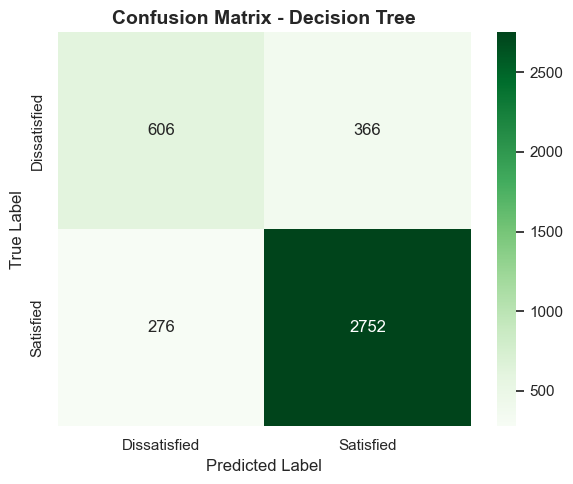

In [79]:
from sklearn.metrics import confusion_matrix

# Step 5: Make predictions on the test set
y_pred = xgb_model.predict(X_test)

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Calculate correctly and incorrectly classified predictions
correctly_classified = (y_pred == y_test).sum()
incorrectly_classified = (y_pred != y_test).sum()

# Print the results
print(f"Correctly classified predictions: {correctly_classified}")
print(f"Incorrectly classified predictions: {incorrectly_classified}")

# Labels for the confusion matrix plot
labels = ['Dissatisfied', 'Satisfied']

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix - Decision Tree", fontsize=14, fontweight='bold')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

In [80]:
# Step 7: Prepare classification metrics for plotting
class_metrics = report_df.loc[['Dissatisfied', 'Satisfied'], ['precision', 'recall', 'f1-score']]
class_metrics = class_metrics.reset_index().melt(id_vars='index', var_name='Metric', value_name='Score')
class_metrics.rename(columns={'index': 'Class'}, inplace=True)
class_metrics['Score'] = class_metrics['Score'] * 100


In [81]:
# Extract accuracy
accuracy_percent = float(report_df.loc['accuracy', 'precision']) * 100
accuracy_label = f"Overall Accuracy: {accuracy_percent:.2f}%"


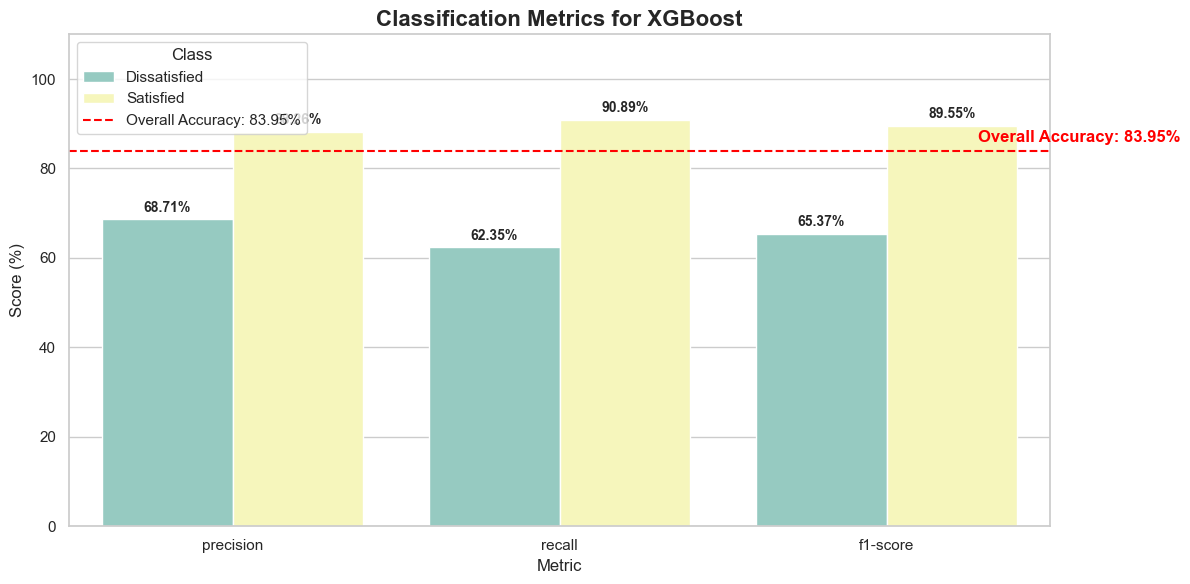

,precision,recall,f1-score,support
Dissatisfied,0.6871,0.6235,0.6537,972.0
Satisfied,0.8826,0.9089,0.8955,3028.0
accuracy,0.8395,NaN,NaN,NaN
macro avg,0.7848,0.7662,0.7746,4000.0
weighted avg,0.8351,0.8395,0.8368,4000.0


In [82]:
# Step 8: Plot classification metrics with accuracy line
plt.figure(figsize=(12, 6))
ax = sns.barplot(data=class_metrics, x='Metric', y='Score', hue='Class', palette='Set3')

# Add labels to bars
for bar in ax.patches:
    height = bar.get_height()
    if height > 0:
        x = bar.get_x() + bar.get_width() / 2
        ax.text(x, height + 1, f'{height:.2f}%', ha='center', va='bottom', fontsize=10, weight='bold')

# Add overall accuracy line
plt.axhline(accuracy_percent, color='red', linestyle='--', linewidth=1.5, label=accuracy_label)
plt.text(2.9, accuracy_percent + 2, accuracy_label, color='red', fontsize=12, ha='right', fontweight='bold')

plt.ylim(0, 110)
plt.title('Classification Metrics for XGBoost', fontsize=16, fontweight='bold')
plt.ylabel('Score (%)')
plt.xlabel('Metric')
plt.legend(title='Class')
plt.tight_layout()
plt.show()

# Output classification report DataFrame
report_df

#### Training and Testing Accuracy

In [83]:
from sklearn.metrics import accuracy_score

# Step 4: Evaluate training and testing accuracy
# Predict on training and test data
y_train_pred = xgb_model.predict(X_train)
y_test_pred = xgb_model.predict(X_test)

# Calculate accuracy for training and testing sets
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

# Print the results
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Testing Accuracy: {test_accuracy:.4f}")


Training Accuracy: 0.8676
Testing Accuracy: 0.8395


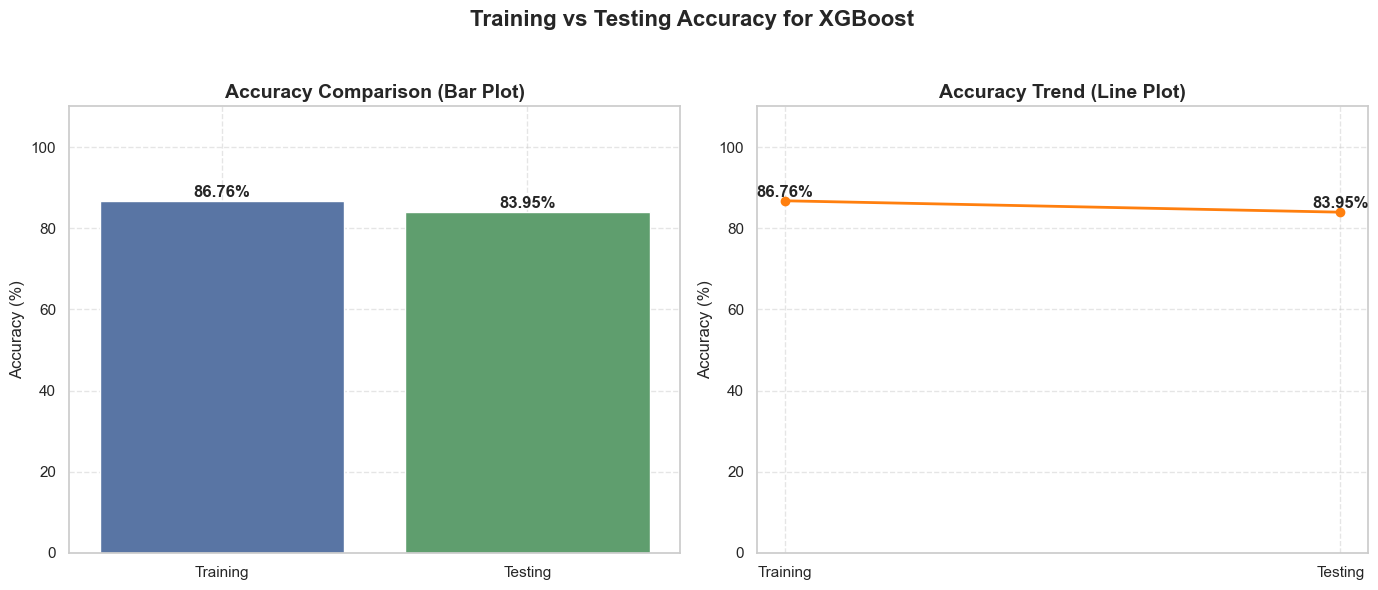

In [84]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import warnings

warnings.filterwarnings("ignore", category=UserWarning, module='matplotlib')

# Step 5: Prepare data for visualization
accuracy_data = pd.DataFrame({
    'Data Split': ['Training', 'Testing'],
    'Accuracy': [train_accuracy * 100, test_accuracy * 100]
})

# Custom color palette
bar_colors = ['#4C72B0', '#55A868']  # Blue and green tones
line_color = '#FF7F0E'               # Orange tone for line plot

# Step 6: Create subplot layout
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# --- Bar Plot ---
sns.barplot(ax=axes[0], data=accuracy_data, x='Data Split', y='Accuracy', palette=bar_colors)

# Add accuracy labels on bars
for i, row in accuracy_data.iterrows():
    axes[0].text(i, row['Accuracy'] + 1, f"{row['Accuracy']:.2f}%", ha='center', fontsize=12, fontweight='bold')

# Style bar plot
axes[0].set_ylim(0, 110)
axes[0].set_title('Accuracy Comparison (Bar Plot)', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Accuracy (%)')
axes[0].set_xlabel('')
axes[0].grid(True, linestyle='--', alpha=0.5)

# --- Line Plot ---
# Convert to numeric index for line plot
x_ticks = range(len(accuracy_data))
axes[1].plot(x_ticks, accuracy_data['Accuracy'], marker='o', color=line_color, linewidth=2)

# Add data point labels
for i, acc in enumerate(accuracy_data['Accuracy']):
    axes[1].text(i, acc + 1, f"{acc:.2f}%", ha='center', fontsize=12, fontweight='bold')

# Set x-axis labels
axes[1].set_xticks(x_ticks)
axes[1].set_xticklabels(accuracy_data['Data Split'])
axes[1].set_ylim(0, 110)

# Style line plot
axes[1].set_title('Accuracy Trend (Line Plot)', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Accuracy (%)')
axes[1].set_xlabel('')
axes[1].grid(True, linestyle='--', alpha=0.5)

# Final layout
plt.suptitle('Training vs Testing Accuracy for XGBoost', fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

#### Model Interpretability

* XGBoost provides built-in feature importances and works efficiently with SHAP.

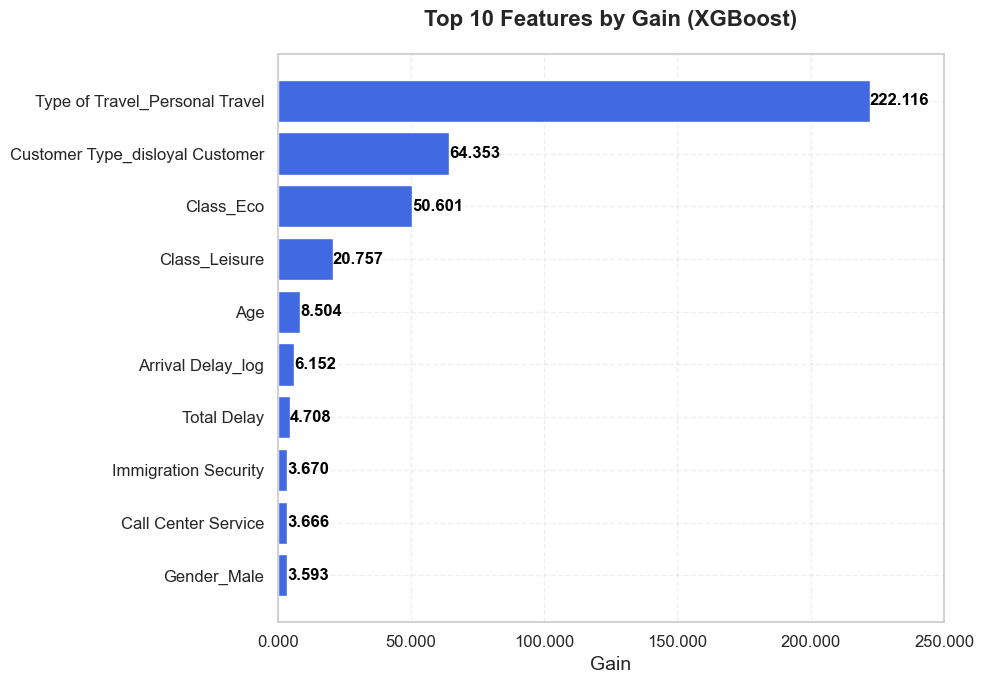

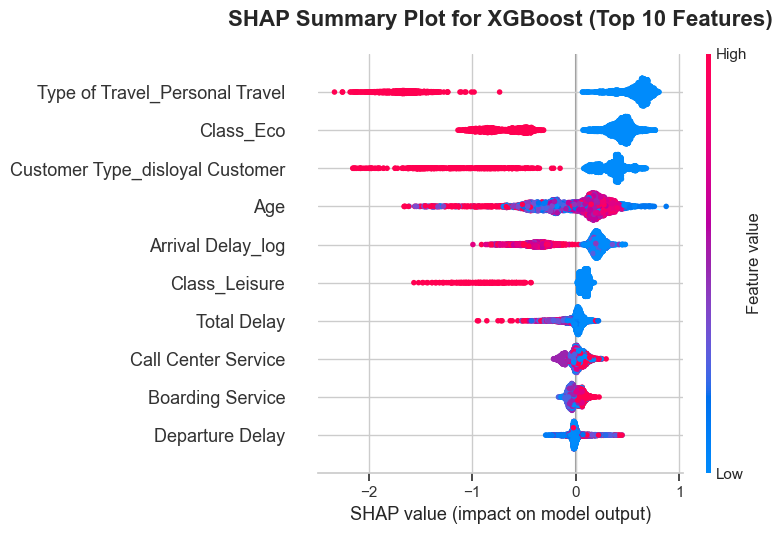

In [107]:
import xgboost as xgb
import matplotlib.pyplot as plt
import shap
import pandas as pd

# Ensure feature names are set
xgb_model.get_booster().feature_names = X_train.columns.tolist()

# --- XGBoost Feature Importance Plot ---
# Get raw feature importances
importance_df = xgb_model.get_booster().get_score(importance_type='gain')
importance_df = pd.DataFrame.from_dict(importance_df, orient='index', columns=['Gain'])
importance_df.index.name = 'Feature'
importance_df.reset_index(inplace=True)

# Get top 10 features by gain
top10 = importance_df.sort_values(by='Gain', ascending=False).head(10)

# Plot manually for more control
plt.figure(figsize=(10, 7))
bars = plt.barh(top10['Feature'][::-1], top10['Gain'][::-1], color='royalblue')

# Add values on the bars
for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2,
             f'{bar.get_width():.3f}', va='center', ha='left', fontsize=12, fontweight='bold', color='black')

# Title and labels
plt.title('Top 10 Features by Gain (XGBoost)', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Gain', fontsize=14)
plt.xticks(ticks=plt.xticks()[0], labels=[f"{x:.3f}" for x in plt.xticks()[0]], fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

# --- SHAP Explanation ---
explainer = shap.Explainer(xgb_model)
shap_values = explainer(X_test)

# SHAP summary plot for top 10 features only with improved styling
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_test, feature_names=X_test.columns, max_display=10, plot_type='dot', 
                  color_bar=True, show=False)

# Customize the SHAP plot title
plt.title('SHAP Summary Plot for XGBoost (Top 10 Features)', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()

# Show plot
plt.show()

#### Key Insight
* Type of Travel_Personal Travel: When the feature value is high (personal travel), the generally positive SHAP values suggest that passengers traveling for personal reasons tend to have higher satisfaction according to the model.

* Class_Eco: The mostly negative SHAP values associated with Economy class indicate that passengers in this class tend to have lower satisfaction based on the model.

* Customer Type_disloyal Customer: The mostly positive SHAP values for disloyal customers suggest that this group tends to have higher satisfaction according to the model. This might seem counterintuitive and warrants further investigation. Perhaps there are specific aspects of the service that particularly satisfy less frequent travelers.

* Age: Younger passengers tend to have a higher satisfaction, while the impact of age is more varied for older passengers.

* Arrival Delay_log: Higher arrival delays lead to lower passenger satisfaction, as indicated by the positive SHAP values (meaning they push the output towards lower satisfaction).

* Class_Leisure: Similar to Economy class, traveling in Leisure class tends to result in lower passenger satisfaction.

* Total Delay: Longer total delays are associated with lower passenger satisfaction.

* Call Center Service: The mixed positive and negative SHAP values suggest that the impact of call center service on passenger satisfaction is complex and not strictly linear. Higher call center service might sometimes increase and sometimes decrease satisfaction depending on other factors.

* Boarding Service: Better boarding service tends to lead to higher passenger satisfaction.

* Departure Delay: Longer departure delays result in lower passenger satisfaction.

* In summary, based on the model's predictions of passenger satisfaction:

* Factors increasing satisfaction: Personal travel, being a disloyal customer, younger age, and better boarding service.
* Factors decreasing satisfaction: Traveling in Economy or Leisure class, and longer arrival and departure delays, and longer total delay.
* Complex impact: Call center service shows a more nuanced relationship with passenger satisfaction.

* This interpretation provides a much clearer understanding of what drives passenger satisfaction according to your model. The seemingly positive impact of being a "disloyal customer" is a particularly interesting insight that could be explored further.

#### All Classical Machine Learning Algoritms In One

In [85]:
# Step 1: Import Libraries
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Import necessary libraries for model training and evaluation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier

In [24]:
# Step 1: Load your dataset (replace the file path with the actual path to your CSV)
data = pd.read_csv('scaled_dataset.csv')

# Assuming that the last column is the target variable
X = data.iloc[:, :-1]  # All columns except the last one as features
y = data.iloc[:, -1]   # The last column as the target

In [25]:
# Step 2: Preprocessing - Train-test split and scaling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [26]:
# Step 3: Initialize models with parameters
models = {
    "Random Forest": RandomForestClassifier(
    n_estimators=200,               # Number of trees in the forest
    criterion='gini',               # Function to measure the quality of a split: 'gini' or 'entropy'
    max_depth=None,                 # Max depth of the tree (None means nodes are expanded until all leaves are pure)
    min_samples_split=2,            # Minimum number of samples required to split an internal node
    min_samples_leaf=1,             # Minimum number of samples required to be at a leaf node
    min_weight_fraction_leaf=0.0,   # Minimum weighted fraction of the sum total of weights required to be at a leaf node
    max_features='sqrt',            # Number of features to consider when looking for the best split
    max_leaf_nodes=None,            # Grow trees with max_leaf_nodes in best-first fashion
    min_impurity_decrease=0.0,      # Node will be split if this split induces a decrease of impurity greater than or equal to this value
    bootstrap=True,                 # Whether bootstrap samples are used when building trees
    oob_score=False,                # Whether to use out-of-bag samples to estimate the generalization score
    n_jobs=-1,                      # Number of jobs to run in parallel (-1 means using all processors)
    random_state=42,                # Seed for reproducibility
    verbose=0,                      # Controls the verbosity when fitting and predicting
    warm_start=False,               # Reuse the solution of the previous call to fit and add more estimators to the ensemble
    class_weight='balanced',        # Automatically adjust weights inversely proportional to class frequencies
    ccp_alpha=0.0,                  # Complexity parameter used for Minimal Cost-Complexity Pruning
    max_samples=None                # Number of samples to draw from X to train each base estimator (only if bootstrap=True)
),
    "Logistic Regression": LogisticRegression(
    class_weight='balanced',    # Handle class imbalance by adjusting weights
    max_iter=1000,              # Increase max iterations to ensure convergence
    random_state=42,            # Set random seed for reproducibility
    C=0.01,                     # Regularization strength (smaller = stronger regularization)
    penalty='l1',               # Use L1 regularization (feature selection)
    solver='saga',              # 'saga' solver supports L1 with large datasets   
    ),
    
    "Decision Tree": DecisionTreeClassifier(
    criterion='gini',            # Use Gini impurity (best from tuning)
    max_depth=5,                 # Limit depth to prevent overfitting (best from tuning)
    min_samples_split=20,        # Require at least 20 samples to split (best from tuning)
    min_samples_leaf=5,          # Require at least 5 samples per leaf (best from tuning)
    max_features=None,           # Consider all features at each split (best from tuning)
    random_state=42,              # Set random seed for reproducibility
    ),
    "SVM": SVC(kernel='linear', C=1.0, gamma='scale'),
    "XGBoost": XGBClassifier(n_estimators=100, max_depth=5, learning_rate=0.1, objective='multi:softmax', num_class=3)
}

In [27]:
# Step 4: Train the models and evaluate accuracies
results = []

for model_name, model in models.items():
    model.fit(X_train, y_train)
    
    # Training and testing accuracy
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    
    results.append({
        "Model": model_name,
        "Training Accuracy": train_accuracy * 100,
        "Testing Accuracy": test_accuracy * 100
    })

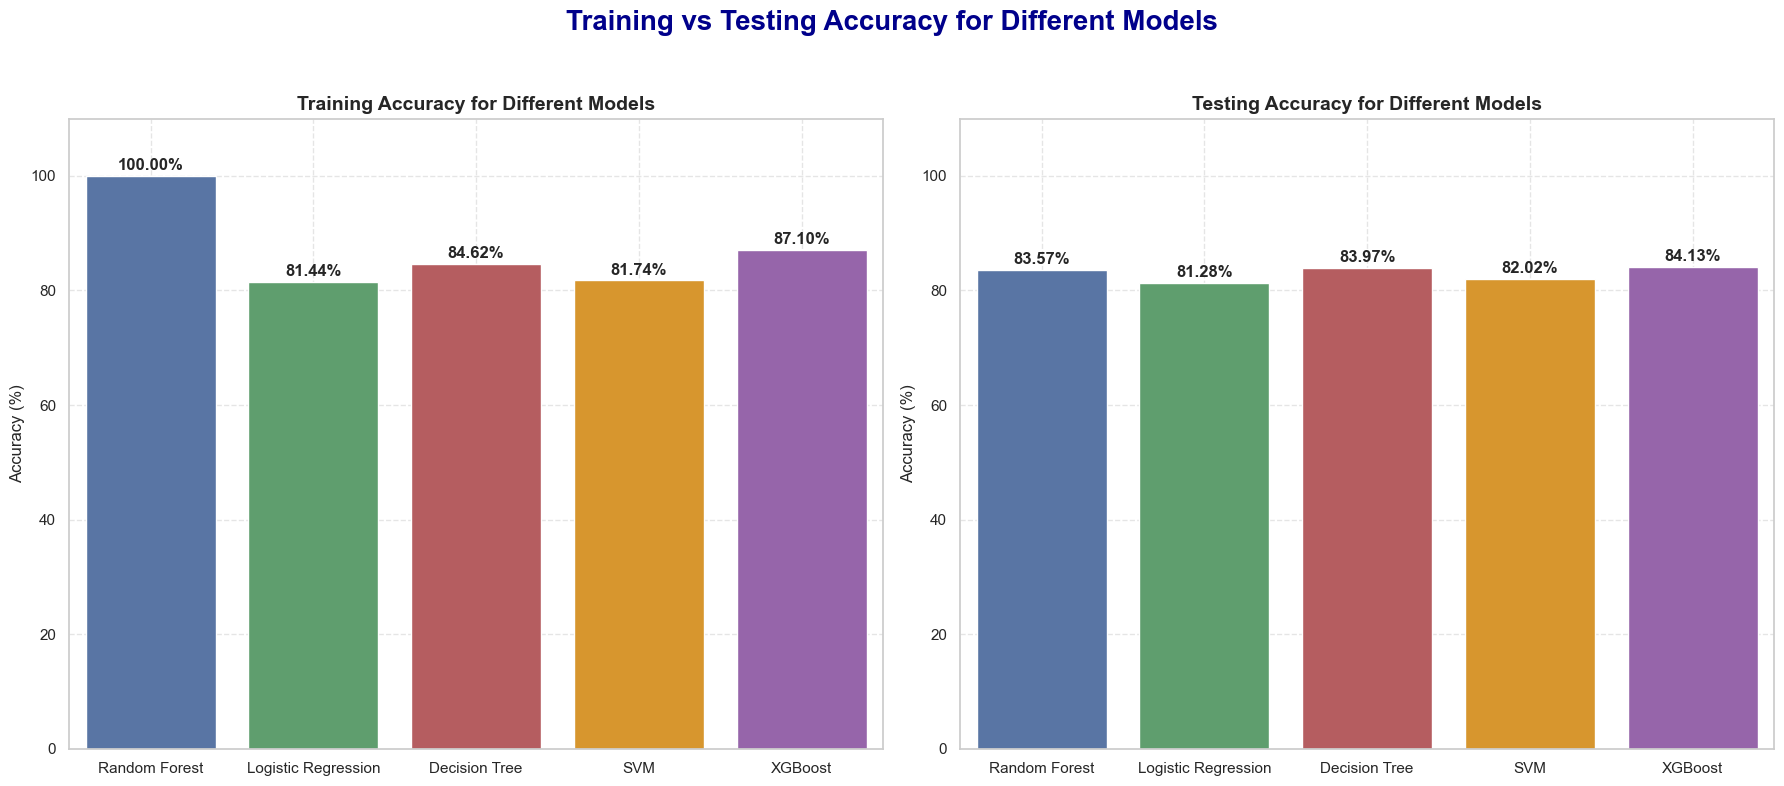

In [28]:
# Step 5: Prepare data for visualization
accuracy_df = pd.DataFrame(results)

# Custom color palettes
bar_colors = ['#4C72B0', '#55A868', '#C44E52', '#F39C12', '#9B59B6']  # Customize colors

# Step 6: Create subplot layout
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# --- Bar Plot for Training Accuracy ---
sns.barplot(ax=axes[0], data=accuracy_df, x='Model', y='Training Accuracy', palette=bar_colors)

# Add accuracy labels on bars for training accuracy
for i, row in accuracy_df.iterrows():
    axes[0].text(i, row['Training Accuracy'] + 1, f"{row['Training Accuracy']:.2f}%", ha='center', fontsize=12, fontweight='bold')

# Style bar plot for training accuracy
axes[0].set_ylim(0, 110)
axes[0].set_title('Training Accuracy for Different Models', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Accuracy (%)')
axes[0].set_xlabel('')
axes[0].grid(True, linestyle='--', alpha=0.5)

# --- Bar Plot for Testing Accuracy ---
sns.barplot(ax=axes[1], data=accuracy_df, x='Model', y='Testing Accuracy', palette=bar_colors)

# Add accuracy labels on bars for testing accuracy
for i, row in accuracy_df.iterrows():
    axes[1].text(i, row['Testing Accuracy'] + 1, f"{row['Testing Accuracy']:.2f}%", ha='center', fontsize=12, fontweight='bold')

# Style bar plot for testing accuracy
axes[1].set_ylim(0, 110)
axes[1].set_title('Testing Accuracy for Different Models', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Accuracy (%)')
axes[1].set_xlabel('')
axes[1].grid(True, linestyle='--', alpha=0.5)

# Final layout
plt.suptitle('Training vs Testing Accuracy for Different Models', fontsize=20, fontweight='bold', color='darkblue')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

#### Classification Report for all Classical Machine Learning Algorithms

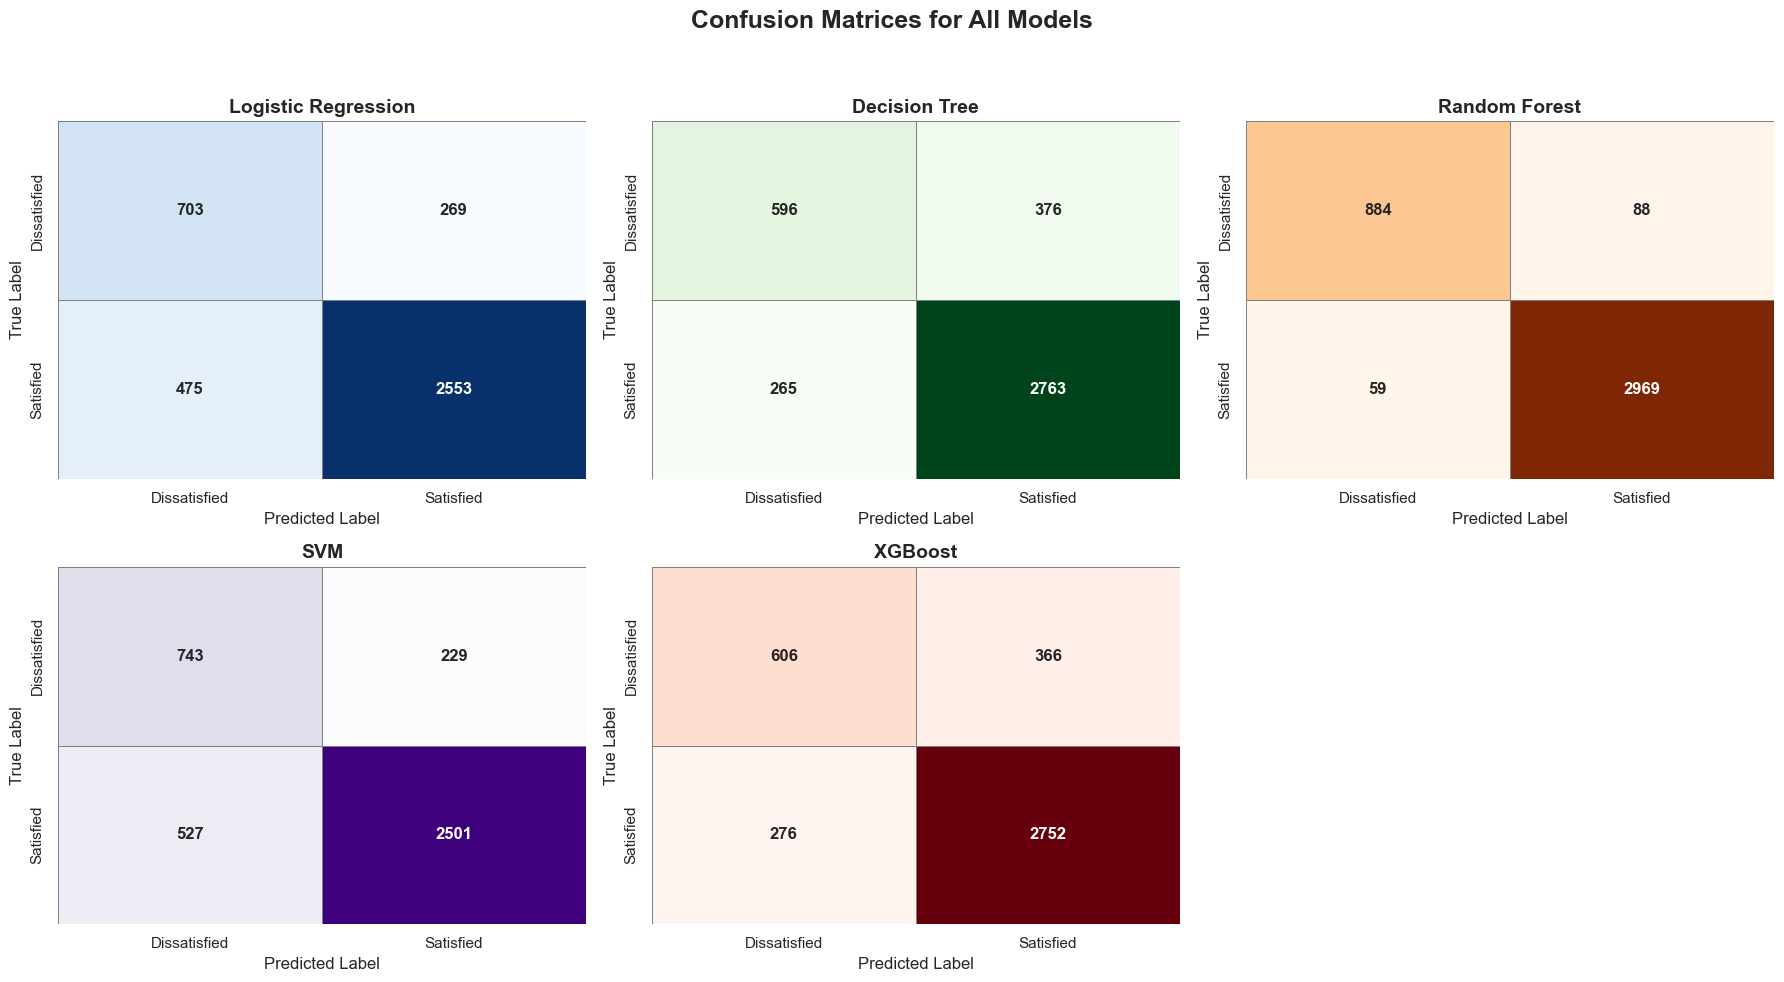

In [88]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Define labels
labels = ['Dissatisfied', 'Satisfied']

# Generate predictions for each model (if not already done)
y_pred_logreg = logreg.predict(X_test)
y_pred_dt = dt_model.predict(X_test)
y_pred_rf = rf_model.predict(X_test)
y_pred_svm = svm_model.predict(X_test)
y_pred_xgb = xgb_model.predict(X_test)

# Prepare predictions in a dictionary
models = {
    "Logistic Regression": (y_pred_logreg, 'Blues'),
    "Decision Tree": (y_pred_dt, 'Greens'),
    "Random Forest": (y_pred_rf, 'Oranges'),
    "SVM": (y_pred_svm, 'Purples'),
    "XGBoost": (y_pred_xgb, 'Reds')
}

# Create subplot layout
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

# Plot confusion matrix for each model with unique colormap
for i, (name, (y_pred, cmap)) in enumerate(models.items()):
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap,
                xticklabels=labels, yticklabels=labels,
                ax=axes[i], cbar=False, linewidths=0.5, linecolor='gray',
                annot_kws={"size": 12, "weight": "bold"})
    axes[i].set_title(f"{name}", fontsize=14, fontweight='bold')
    axes[i].set_xlabel("Predicted Label")
    axes[i].set_ylabel("True Label")
    axes[i].tick_params(labelsize=11)

# Hide the last empty subplot if needed
if len(models) < len(axes):
    axes[-1].axis('off')

# Final layout formatting
plt.suptitle("Confusion Matrices for All Models", fontsize=18, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()
